# Histogram/PDF and Perkins Skill Score (PSS)

Assessment of model histogram/PDF and PSS over the 2000-2019 period.

(Bias corrected data for the period 2000-2019 was produced by training on data from the 1980-1999 period.)

In [21]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import seaborn as sns
from scipy import stats

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [22]:
def calc_mean(da, var):
    """Calculate the mean"""
    
    mean = da.groupby('time.year').mean(dim="time").mean(dim='year')
        
    return mean

In [23]:
def get_data(var, rcm, nrm_region):
    """Get data needed for the evaluation"""

    assert rcm in ['BOM-BARPA-R', 'UQ-DES-CCAM-2105']
    assert nrm_region in ['EA','SA','NA']
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        nrm_region
    )
   
    da_gcm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        'GCM',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        nrm_region
    )
    da_rcm_raw = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        nrm_region
    )
    da_rcm_ecdfm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'ecdfm',
        'task-historical',
        '2000-01-01',
        '2019-12-31',
        nrm_region
    )
    # TODO: Add additional bias correction methods as data becomes available 

    return da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm

In [24]:
def plot_mean_bias(ax, da_obs, da_model, var, model_name, mode, nrm_region):
    """Plot the mean bias for a particular model"""
    
    def calc_pss(ax, mean_obs, mean_model, w, n, start_value, stop_value):
        # get histogram counts and bin edges
        bins = np.arange(start_value, stop_value + w, w)
        obs_counts, obs_bin_edges = np.histogram(mean_obs, bins=bins, density=True)
        model_counts, model_bin_edges = np.histogram(mean_model, bins=bins, density=True)
        # calculate the PSS scores
        min_c_model=[]
        for i in range(0,n):
            min_c_model.append(min(obs_counts[i]/sum(obs_counts), model_counts[i]/sum(model_counts)))
        pss_model = sum(min_c_model)
        return pss_model

    def plot_pdf(ax, mean_obs, mean_model, n, model_name, pss_model):  
        for i,x in enumerate([mean_obs, mean_model]):
            if i == 0:
                label_name='Observation'
                c='green'
            else:
                label_name = model_name
                c='red'
    
            ax=sns.distplot(x, hist=False, kde=True, ax=ax,
                         bins=n,
                         kde_kws={'linewidth': 1.5},
                        label=label_name,
                        color=c)
            
        ax.set_ylabel('PDF', fontsize=12)
        ax.set_xlabel(da_model.name, fontsize=12)
        ax.grid(linestyle=':', color='grey')
        ax.legend(loc='lower center')
        plt.text(0.35, 0.99, 'PSS AGCD-Model = '+str(round(pss_model,2)), fontsize=10, ha='right', va='top', transform=ax.transAxes)
        ax.set_title(model_name+' NRM:'+nrm_region)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

    def plot_hist(ax, mean_obs, mean_model, n, model_name, pss_model):
        for i,x in enumerate([mean_obs, mean_model]):
            if i == 0:
                label_name='Observation'
                c='green'
            else:
                label_name= model_name
                c='red'
            ax=sns.distplot(x, hist=True, kde=False, ax=ax, hist_kws={'histtype': 'step', 'linewidth': 2},
                         bins=n,
                        label=label_name,
                        color=c)
        ax.set_yscale('log')
        ax.set_ylabel('Frequency [log]', fontsize=12) 
        ax.set_xlabel(da_model.name, fontsize=12)
        ax.grid(linestyle=':', color='grey')
        ax.legend(loc='lower center')
        plt.text(0.35, 0.99, 'PSS AGCD-Model = '+str(round(pss_model,2)), fontsize=10, ha='right', va='top', transform=ax.transAxes)
        ax.set_title(model_name+' NRM:'+nrm_region)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)            


    mean_obs = calc_mean(da_obs, var)
    mean_model = calc_mean(da_model, var)
    mean_model = mean_model.where(~np.isnan(mean_obs))  
    
    mean_obs = mean_obs.values.flatten()  
    mean_obs = mean_obs[~np.isnan(mean_obs)]
    mean_model = mean_model.values.flatten()
    mean_model = mean_model[~np.isnan(mean_model)]

    # Define bin widths w and number of bins n for histogram, PDF and PSS
    w=0.2
    start_value = min(min(mean_obs), min(mean_model))
    stop_value = max(max(mean_obs), max(mean_model))
    n = len(np.arange(start_value, stop_value + w, w)) - 1
    
    pss_model = calc_pss(ax, mean_obs, mean_model, w, n, start_value, stop_value)
    
    if mode == 'histogram':
        plot_hist(ax, mean_obs, mean_model, n, model_name, pss_model)
    elif mode == 'PDF':
        plot_pdf(ax, mean_obs, mean_model, n, model_name, pss_model)
    else:
        raise ValueError('Invalid mode')


In [25]:
def plot_comparison(var,rcm,nrm_region):
    """Plot the complete comparison"""

    da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm = get_data(var,rcm,nrm_region)

    modes= ['histogram','PDF']
        
    rows, cols = len(modes), 3  
    
    fig, axs = plt.subplots(rows, cols, figsize=[24, 6*rows])
    
    for row, mode in enumerate(modes):

        ax1 = axs[row, 0]
        ax2 = axs[row, 1]
        ax3 = axs[row, 2]

         # Plot GCM 
        plot_mean_bias(ax1, da_obs, da_gcm, var,  'CSIRO-ACCESS-ESM1-5', mode, nrm_region)
        ax1.set_title(f'CSIRO-ACCESS-ESM1-5 NRM:{nrm_region} ({mode.upper()})', fontsize=14)

        # Plot RCM 
        plot_mean_bias(ax2, da_obs, da_rcm_raw, var,  f'{rcm} (raw)', mode, nrm_region)
        ax2.set_title(f'{rcm} (raw) NRM:{nrm_region} ({mode.upper()})', fontsize=14)

        # Plot RCM bias corrected 
        plot_mean_bias(ax3, da_obs, da_rcm_ecdfm, var,  f'{rcm} (ecdfm)', mode, nrm_region)
        ax3.set_title(f'{rcm} (ecdfm) NRM:{nrm_region} ({mode.upper()})', fontsize=14)
    
    plt.suptitle(f' Histograms/PDFs and PSS for different NRM regions in the 2000-2019 period', fontsize=16)
    plt.show()

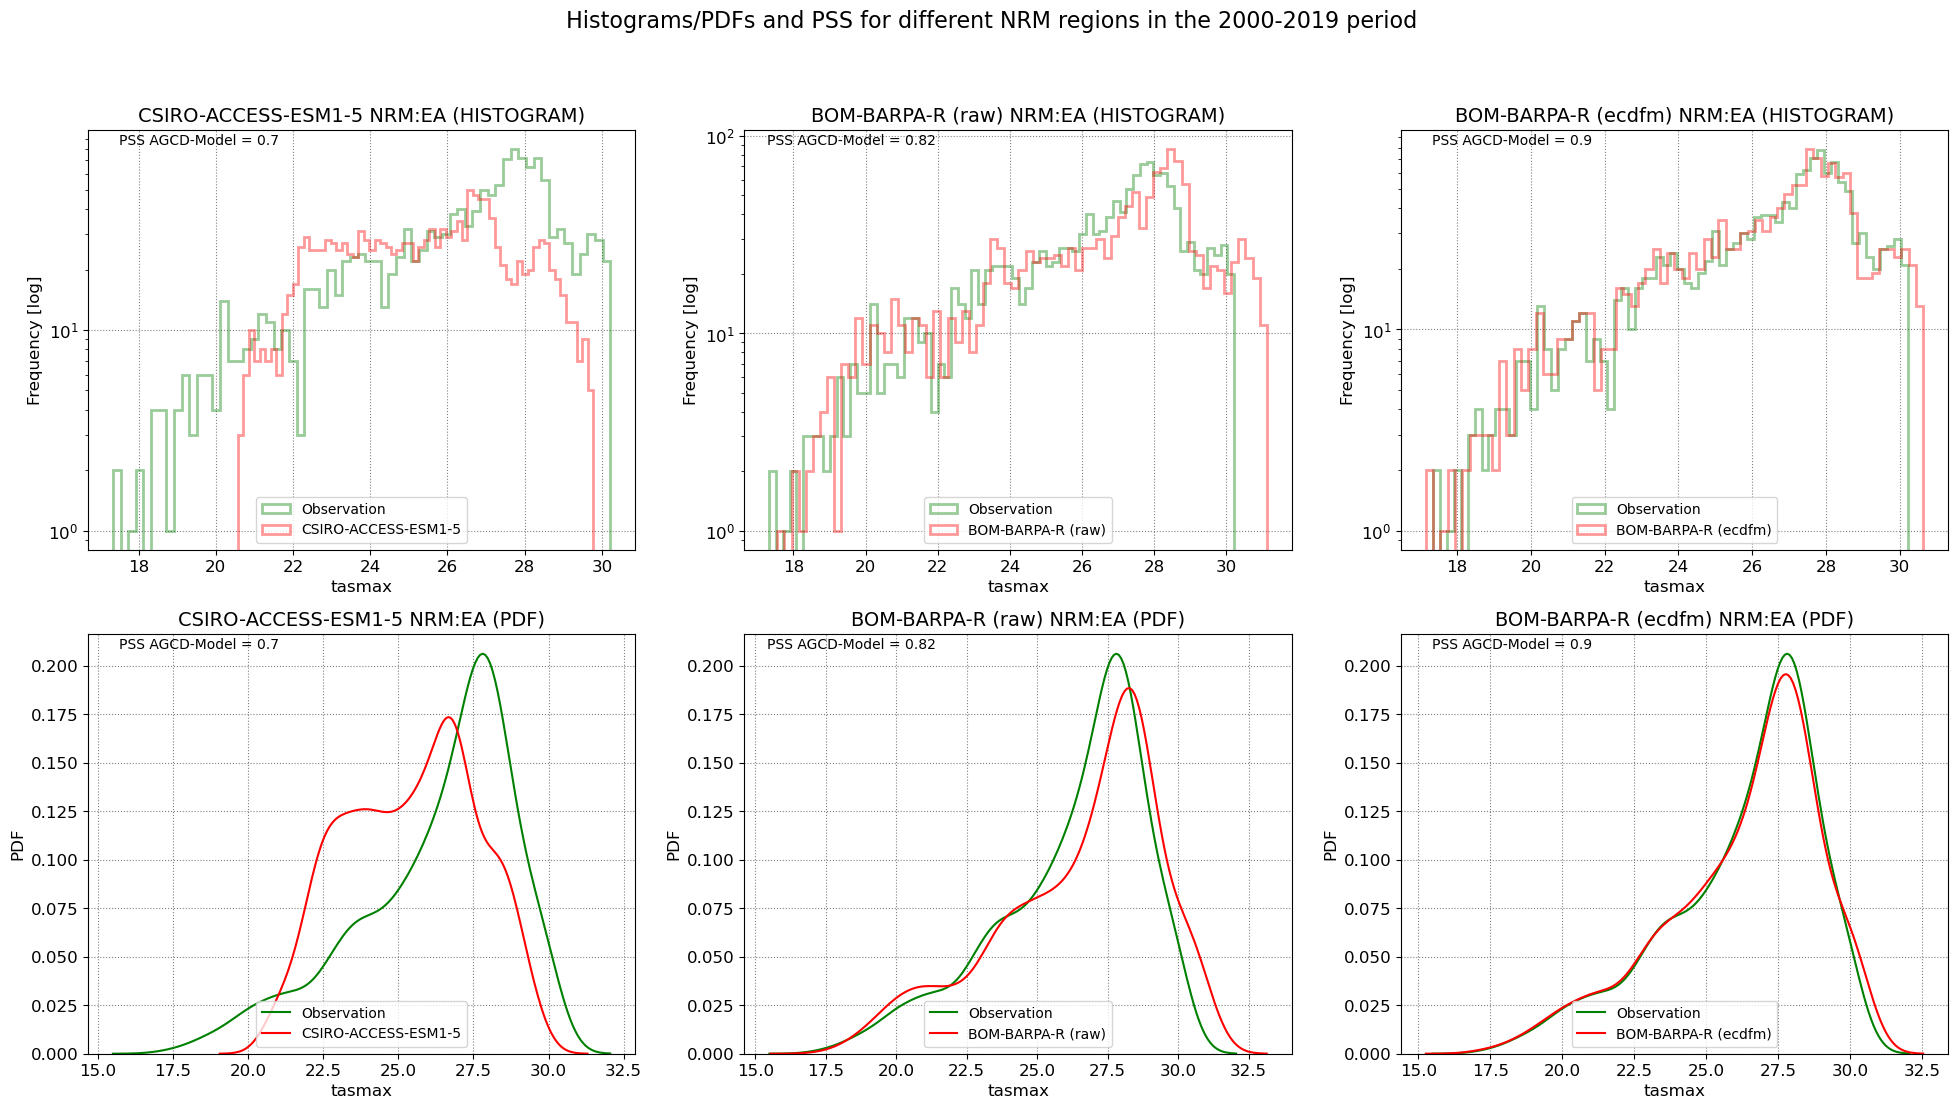

In [26]:
plot_comparison('tasmax','BOM-BARPA-R','EA')

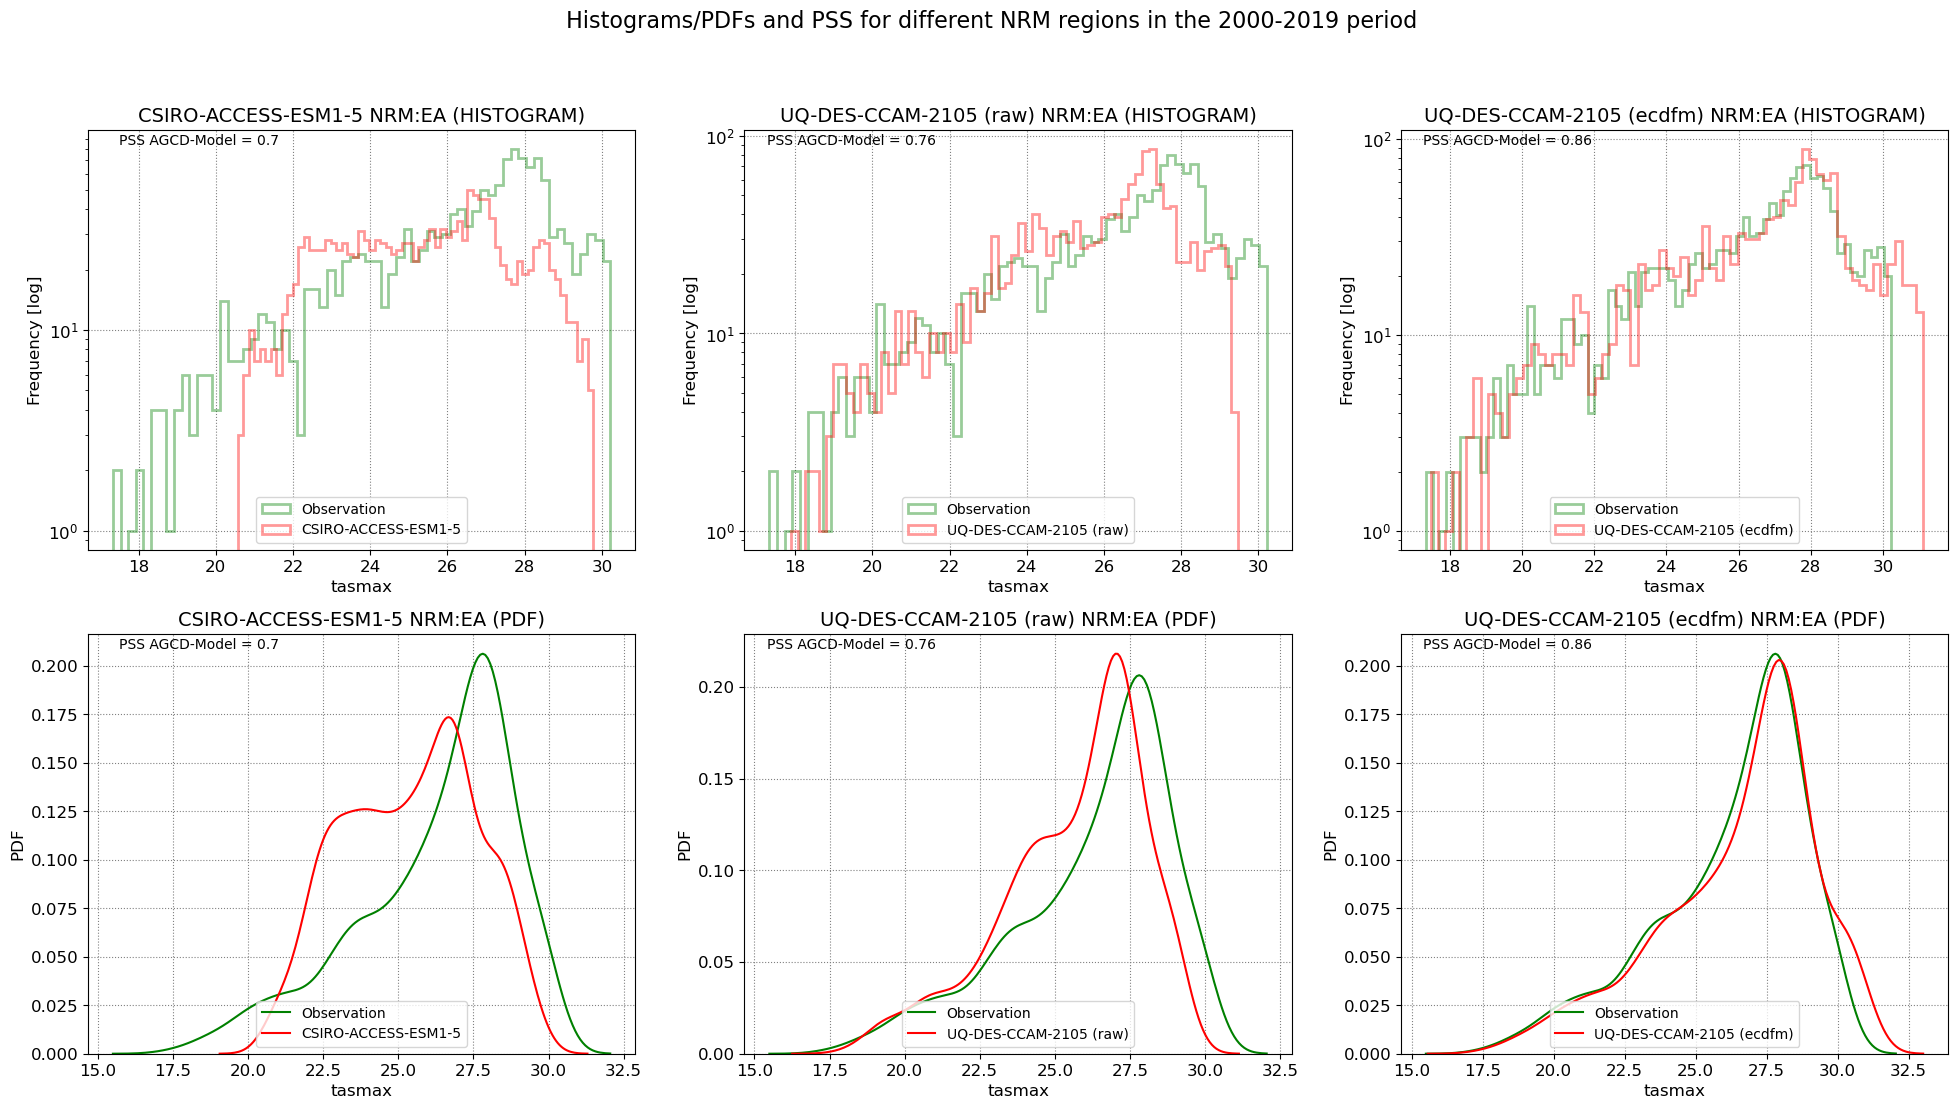

In [27]:
plot_comparison('tasmax','UQ-DES-CCAM-2105','EA')

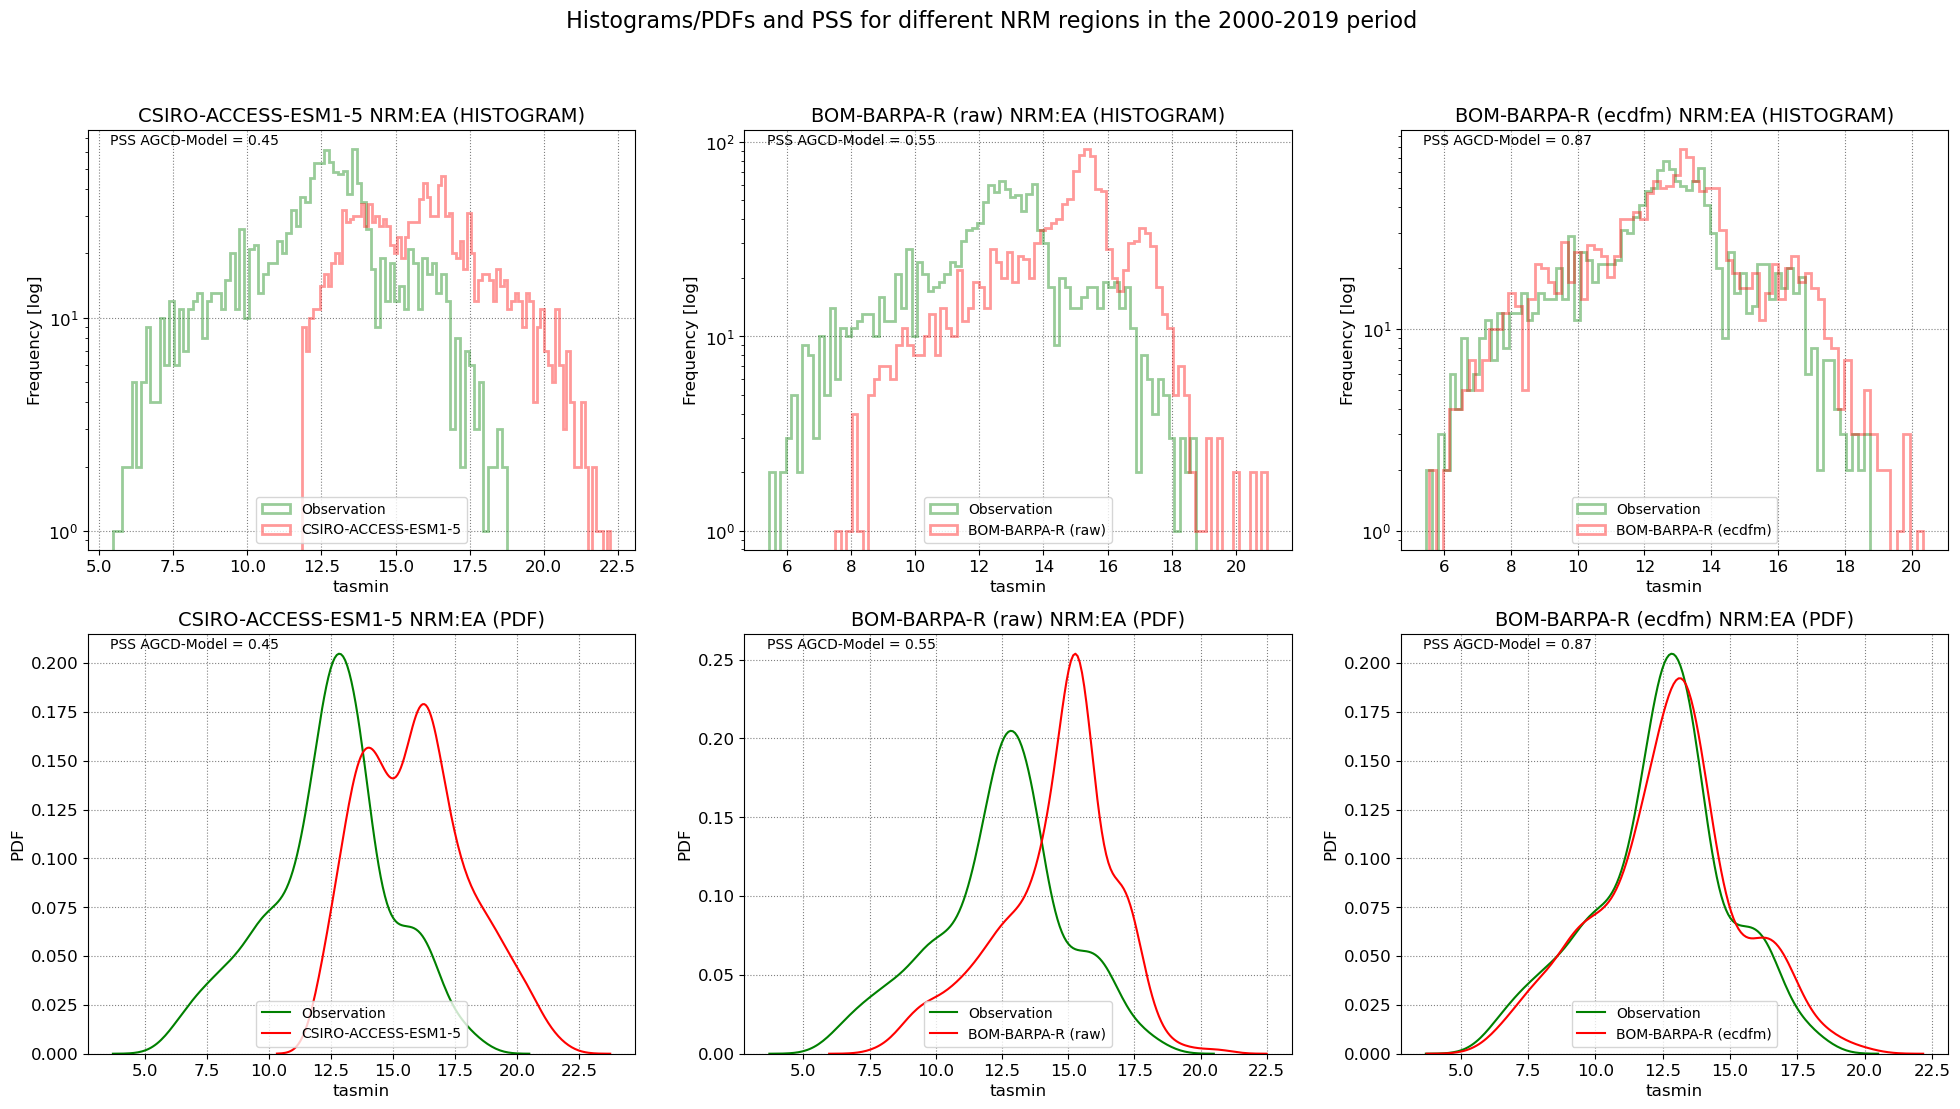

In [28]:
plot_comparison('tasmin','BOM-BARPA-R','EA')

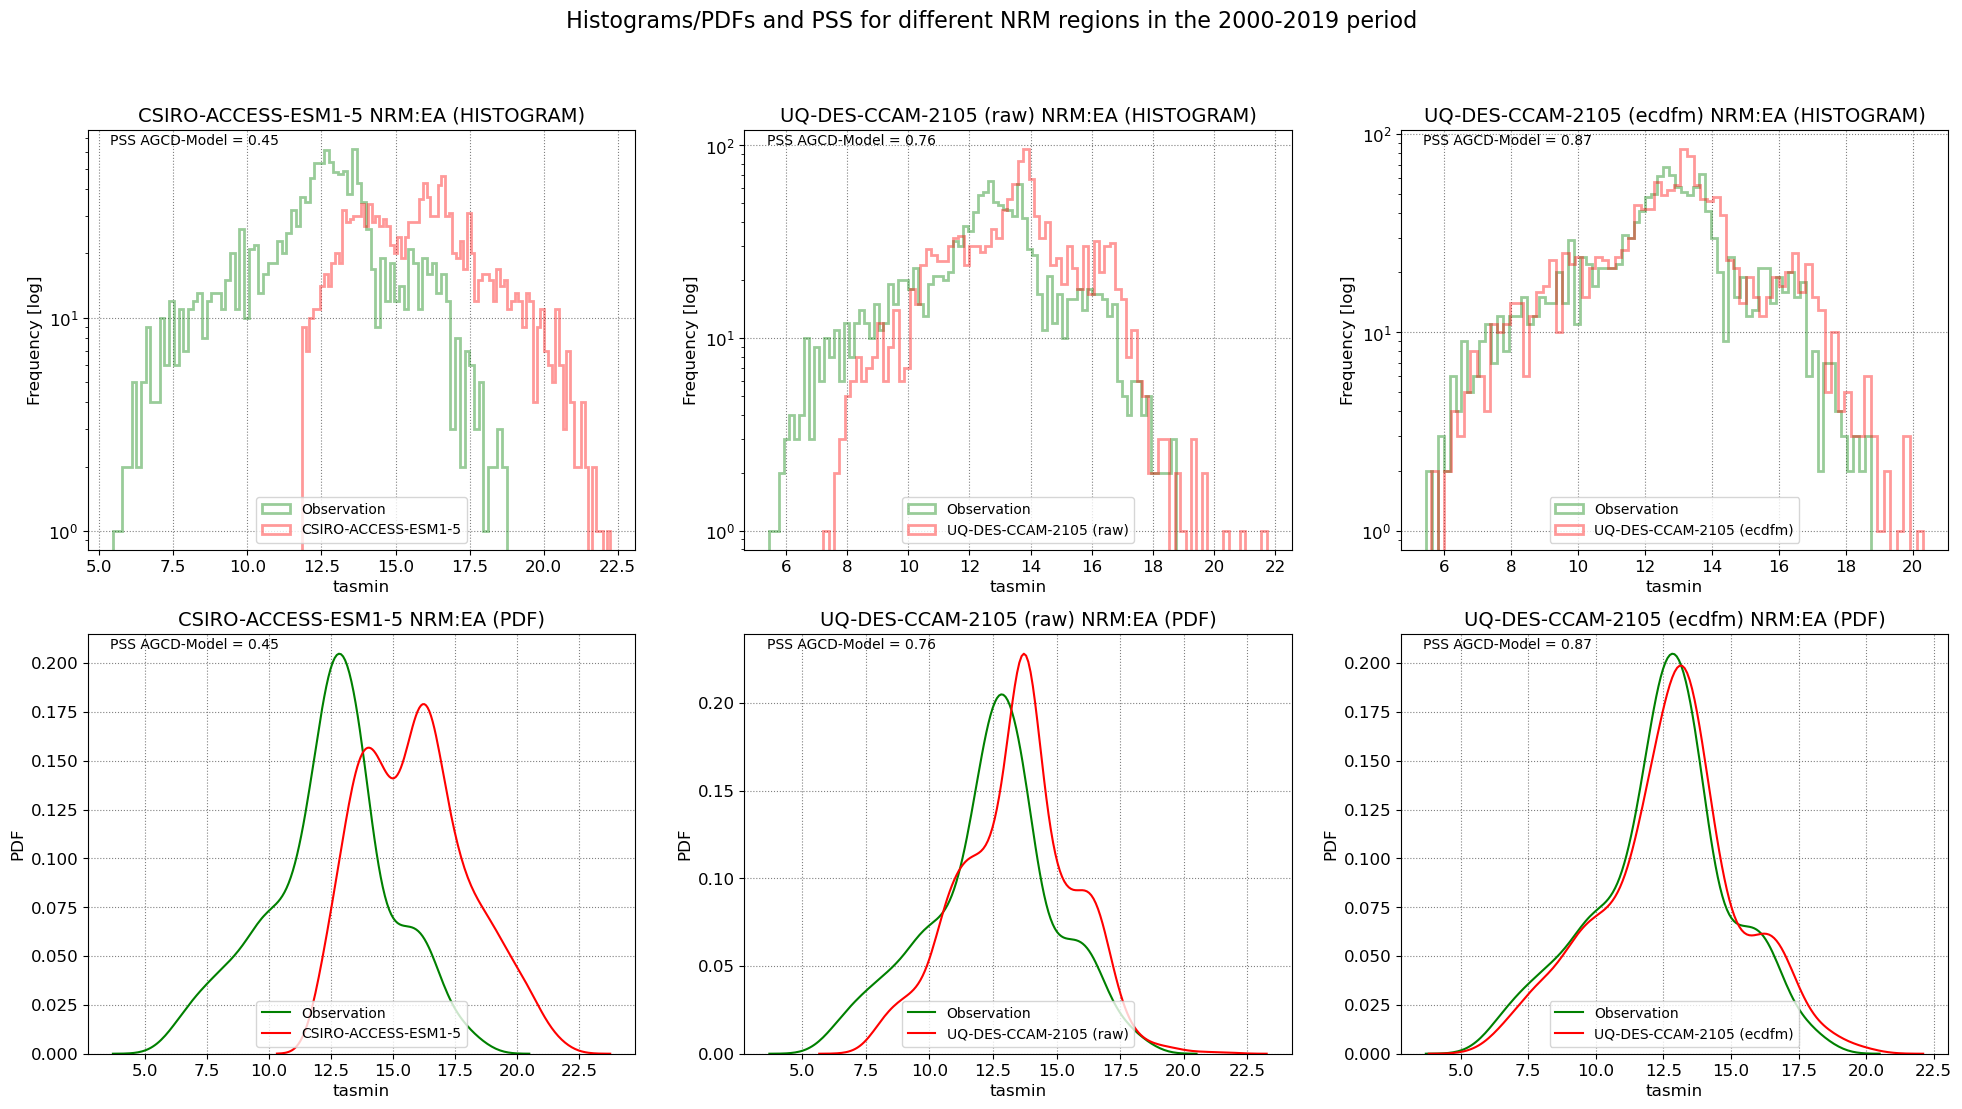

In [29]:
plot_comparison('tasmin','UQ-DES-CCAM-2105','EA')

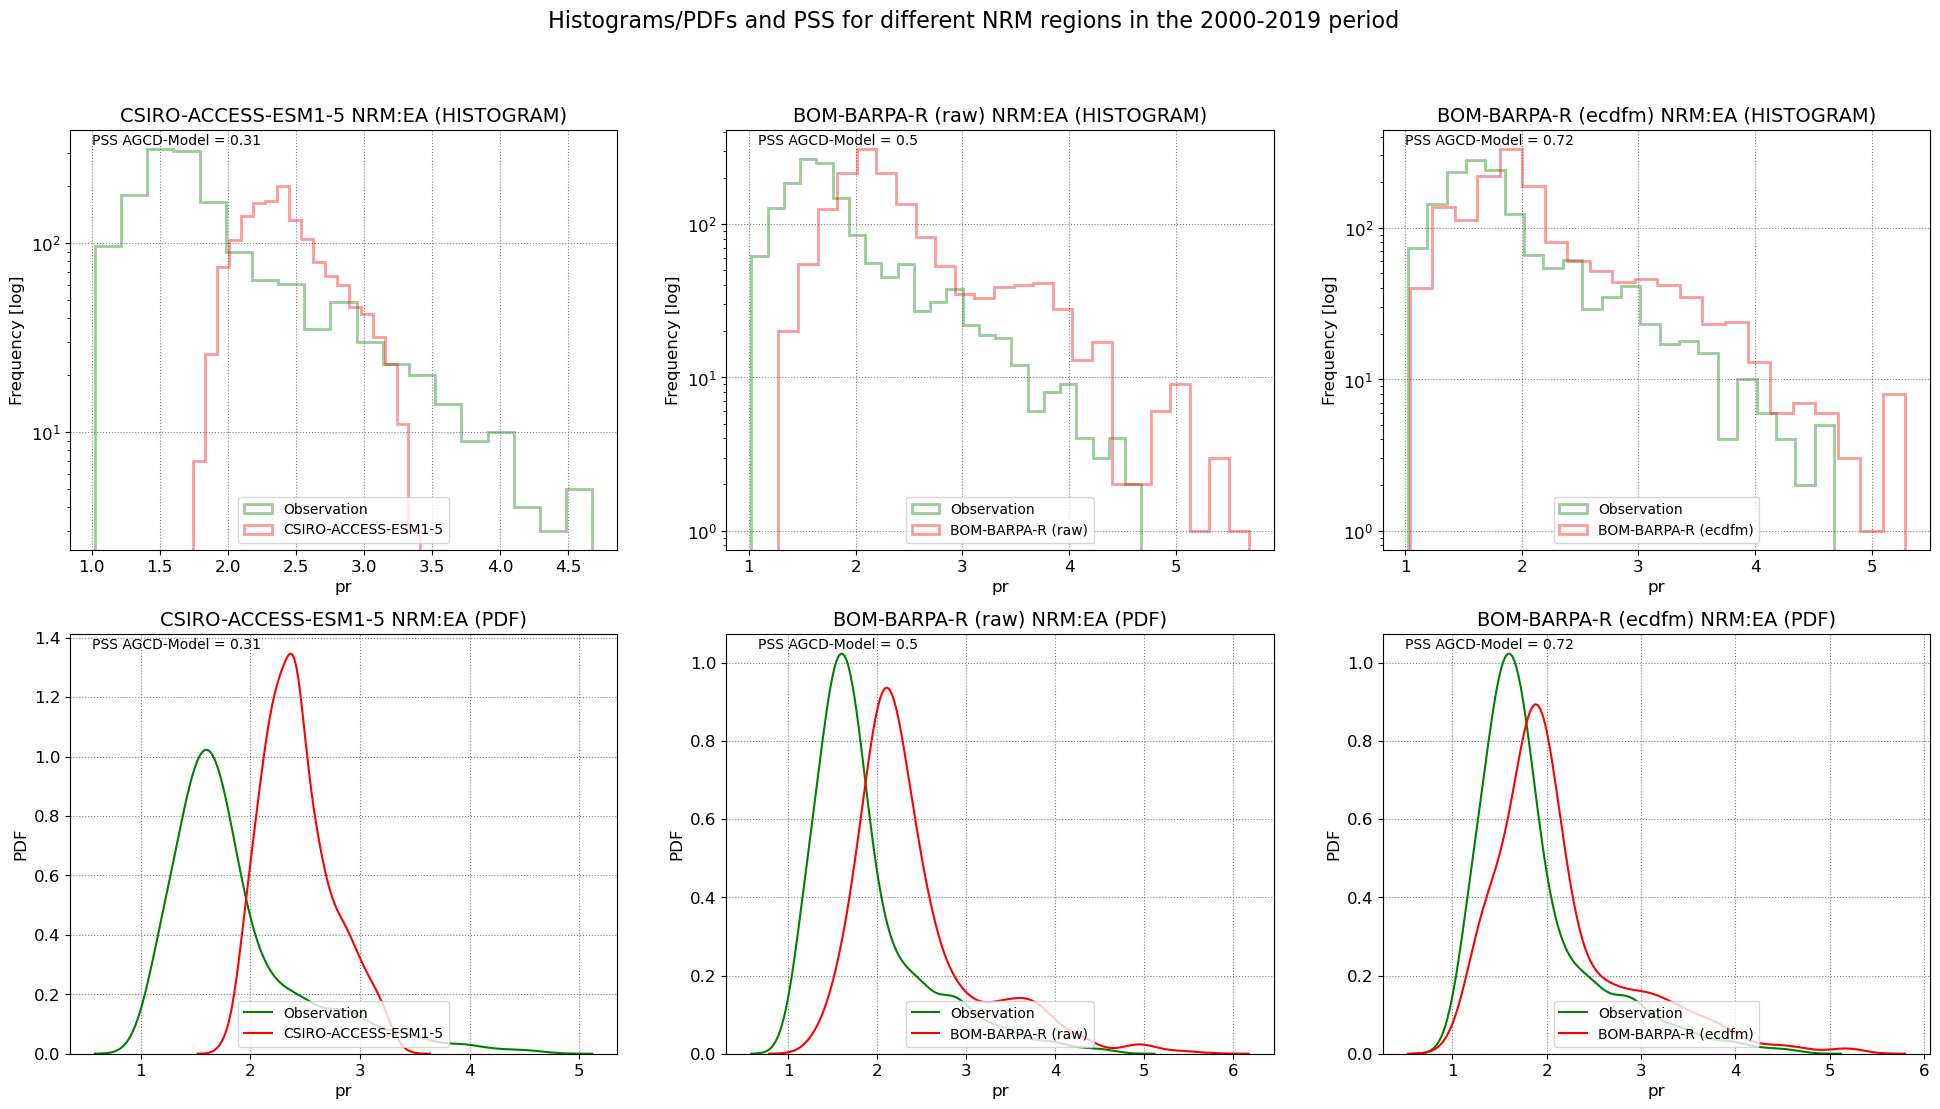

In [30]:
plot_comparison('pr','BOM-BARPA-R','EA')

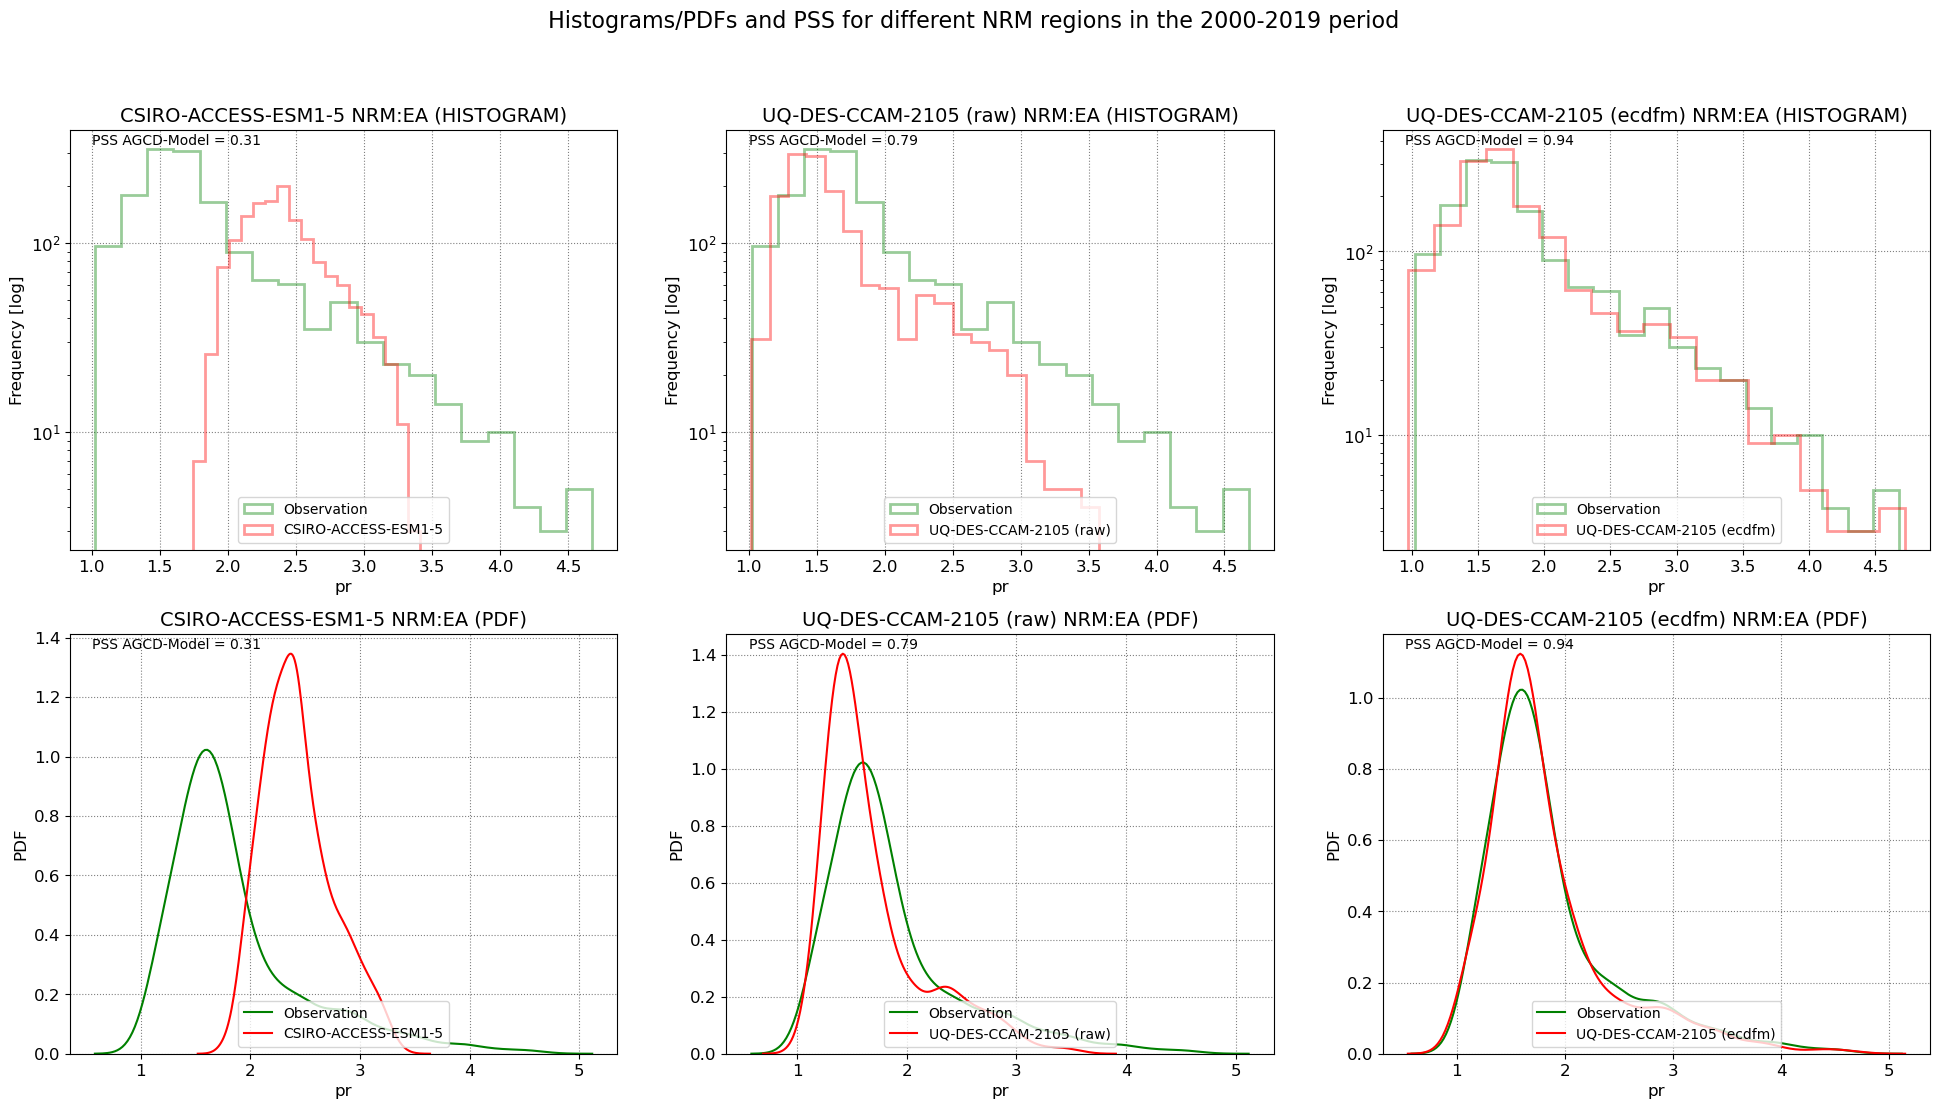

In [31]:
plot_comparison('pr','UQ-DES-CCAM-2105','EA')

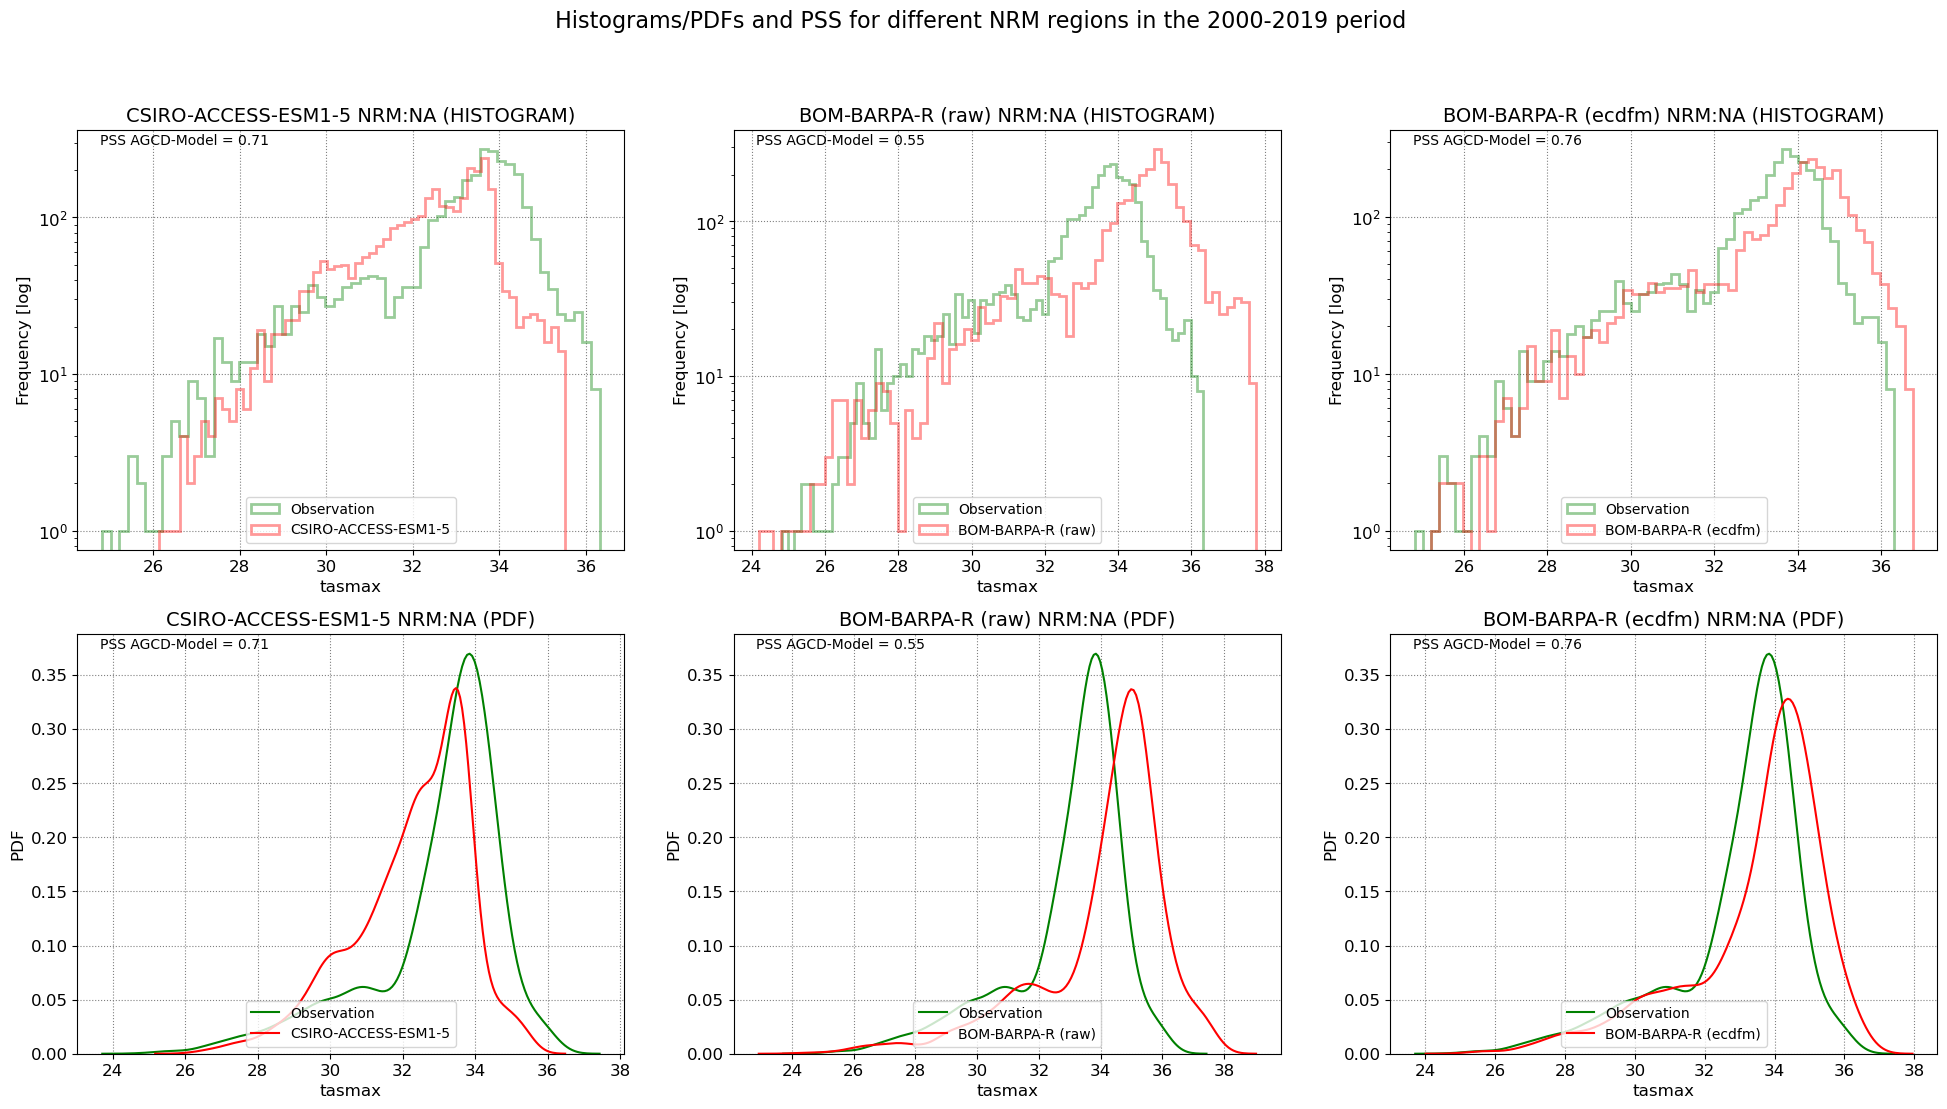

In [32]:
plot_comparison('tasmax','BOM-BARPA-R','NA')

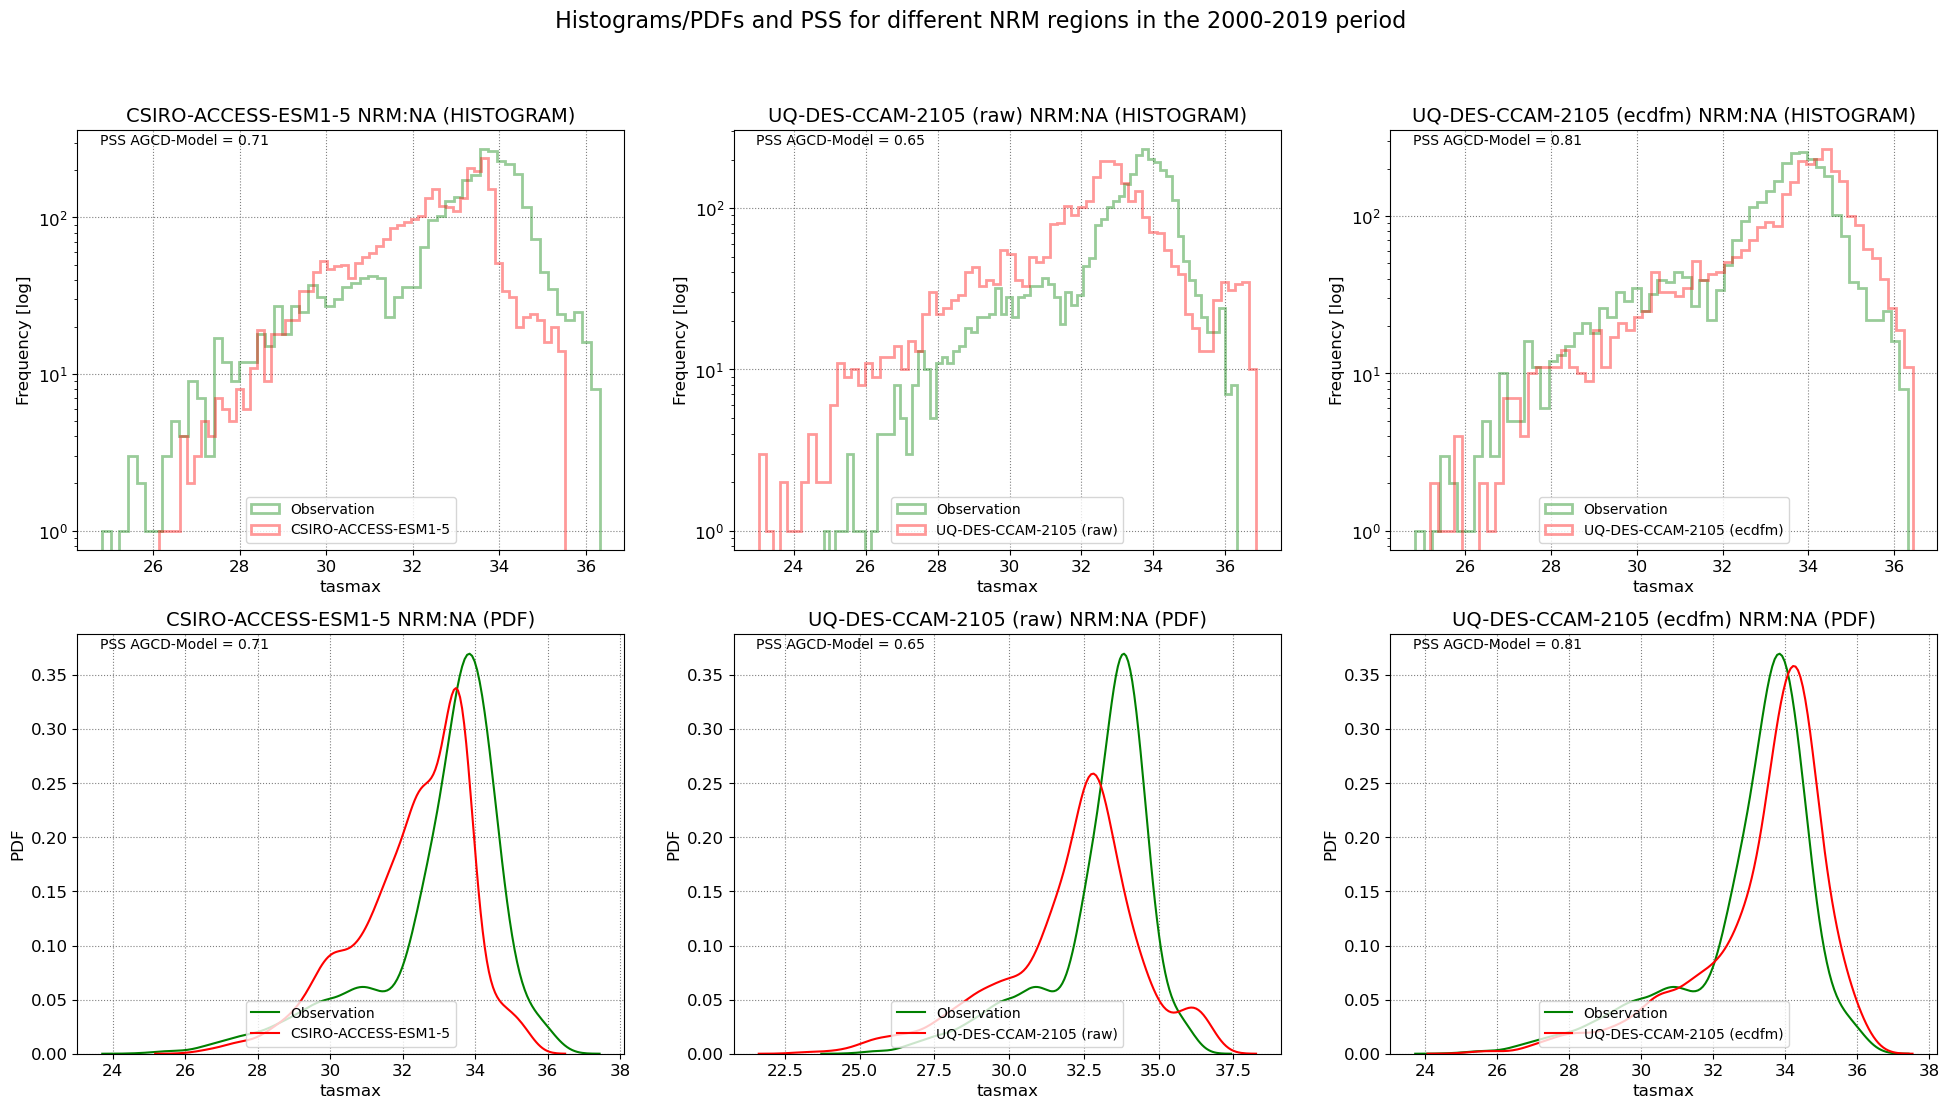

In [33]:
plot_comparison('tasmax','UQ-DES-CCAM-2105','NA')

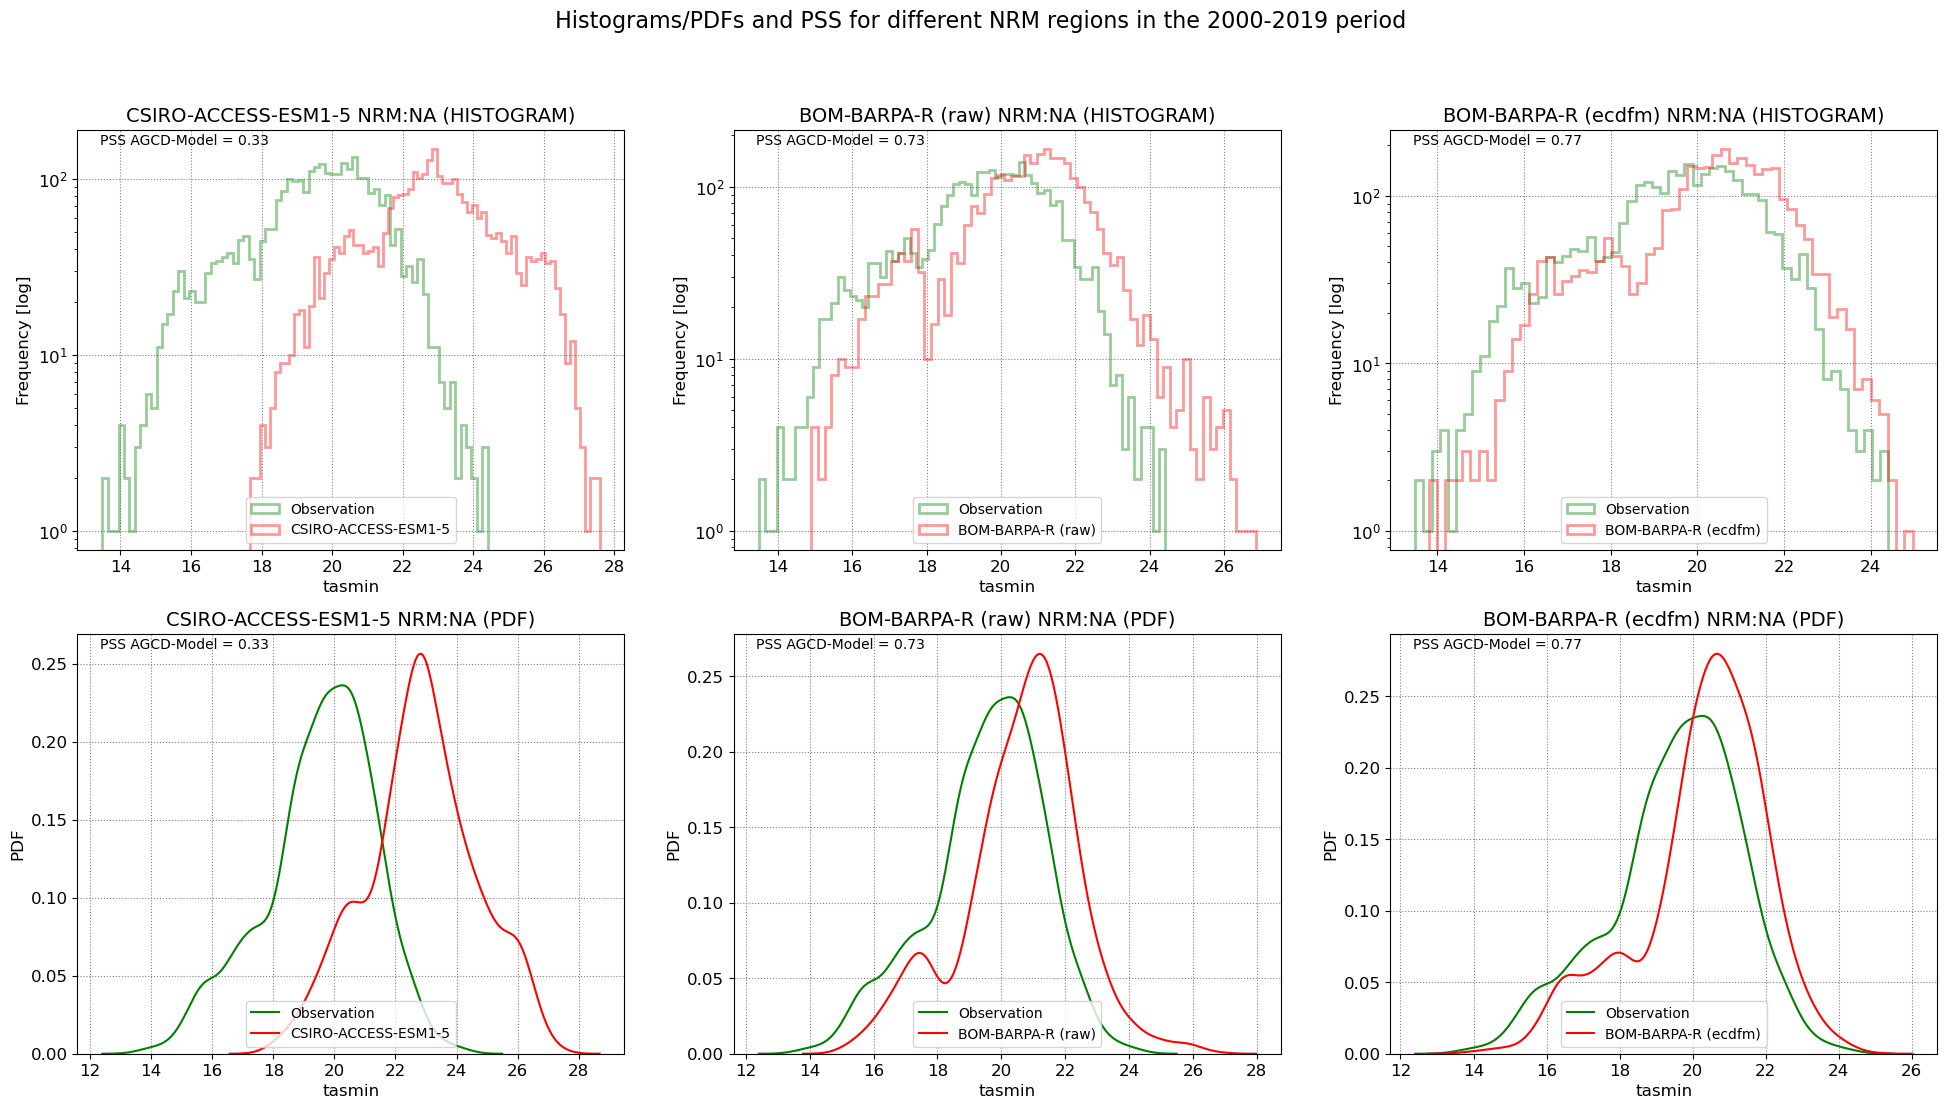

In [34]:
plot_comparison('tasmin','BOM-BARPA-R','NA')

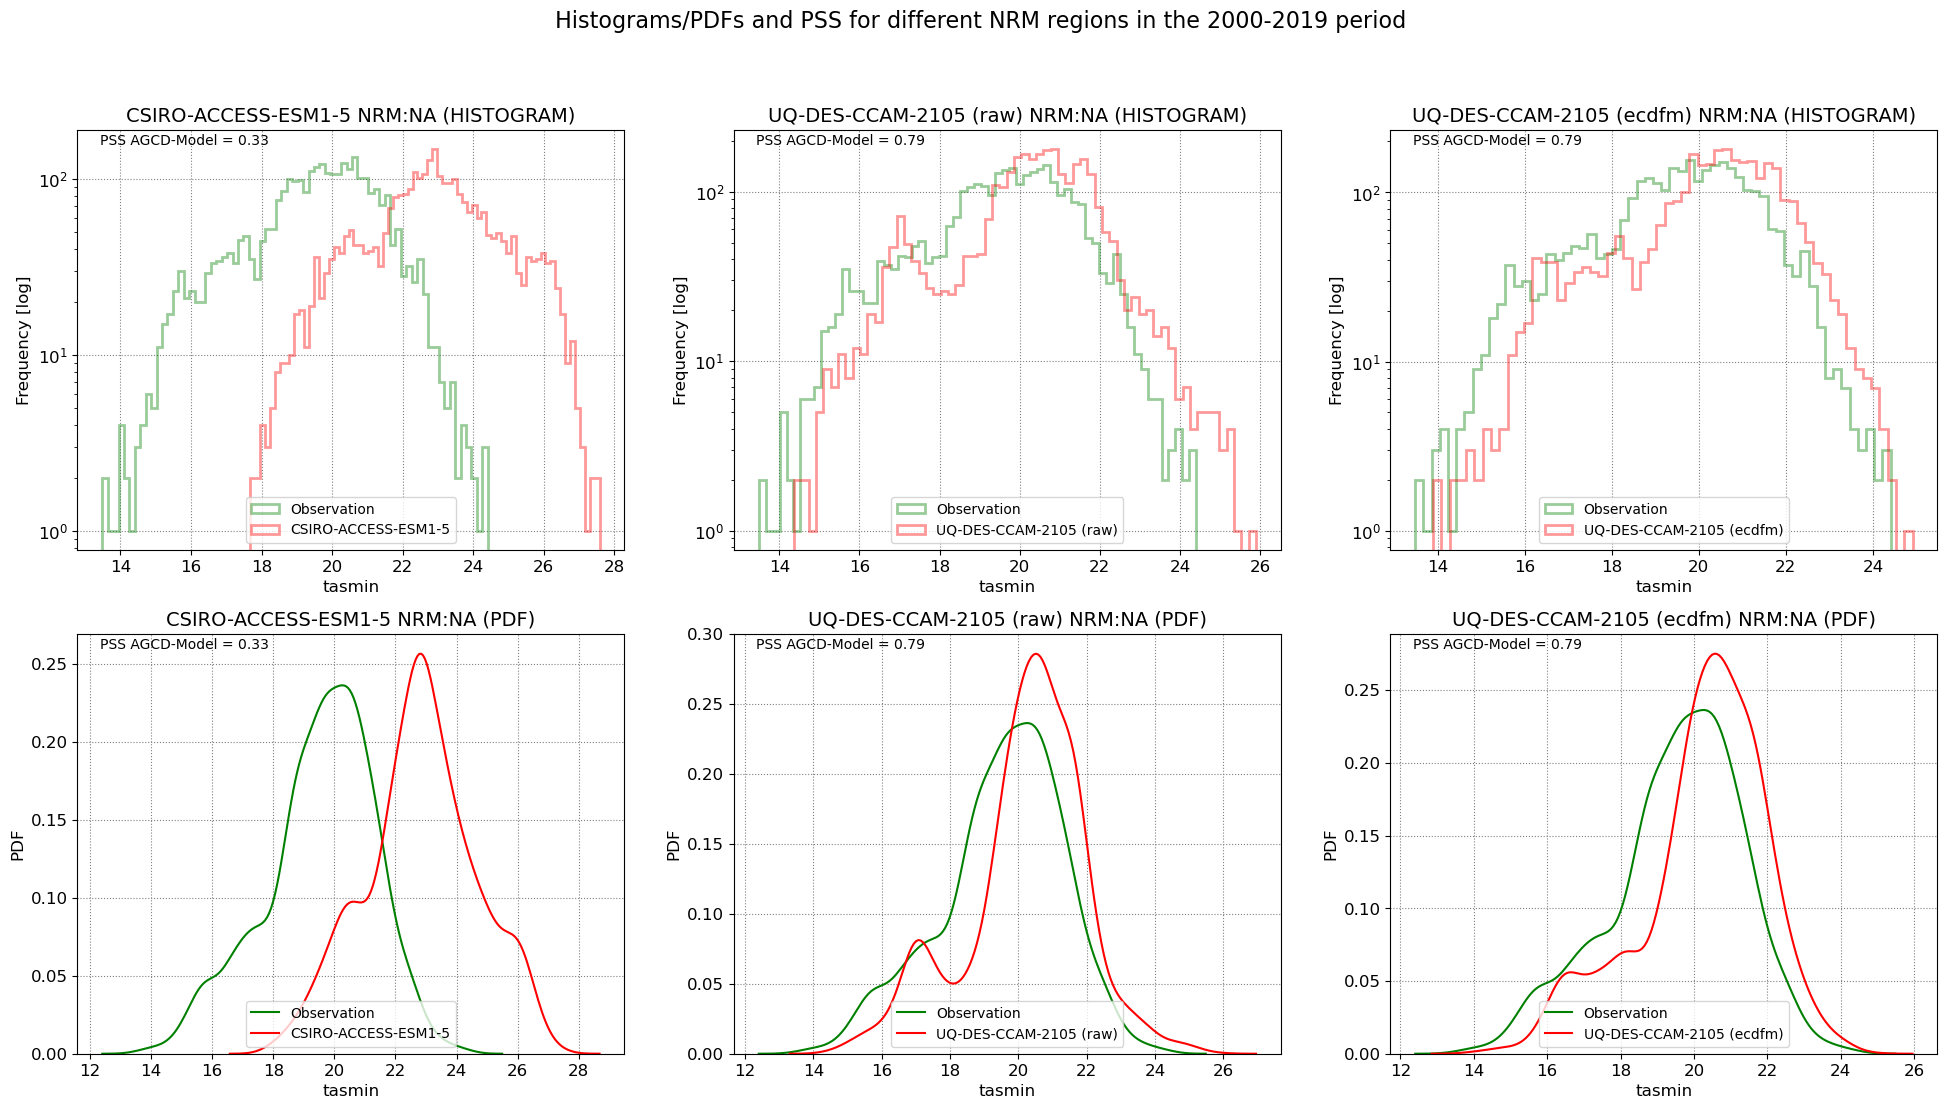

In [35]:
plot_comparison('tasmin','UQ-DES-CCAM-2105','NA')

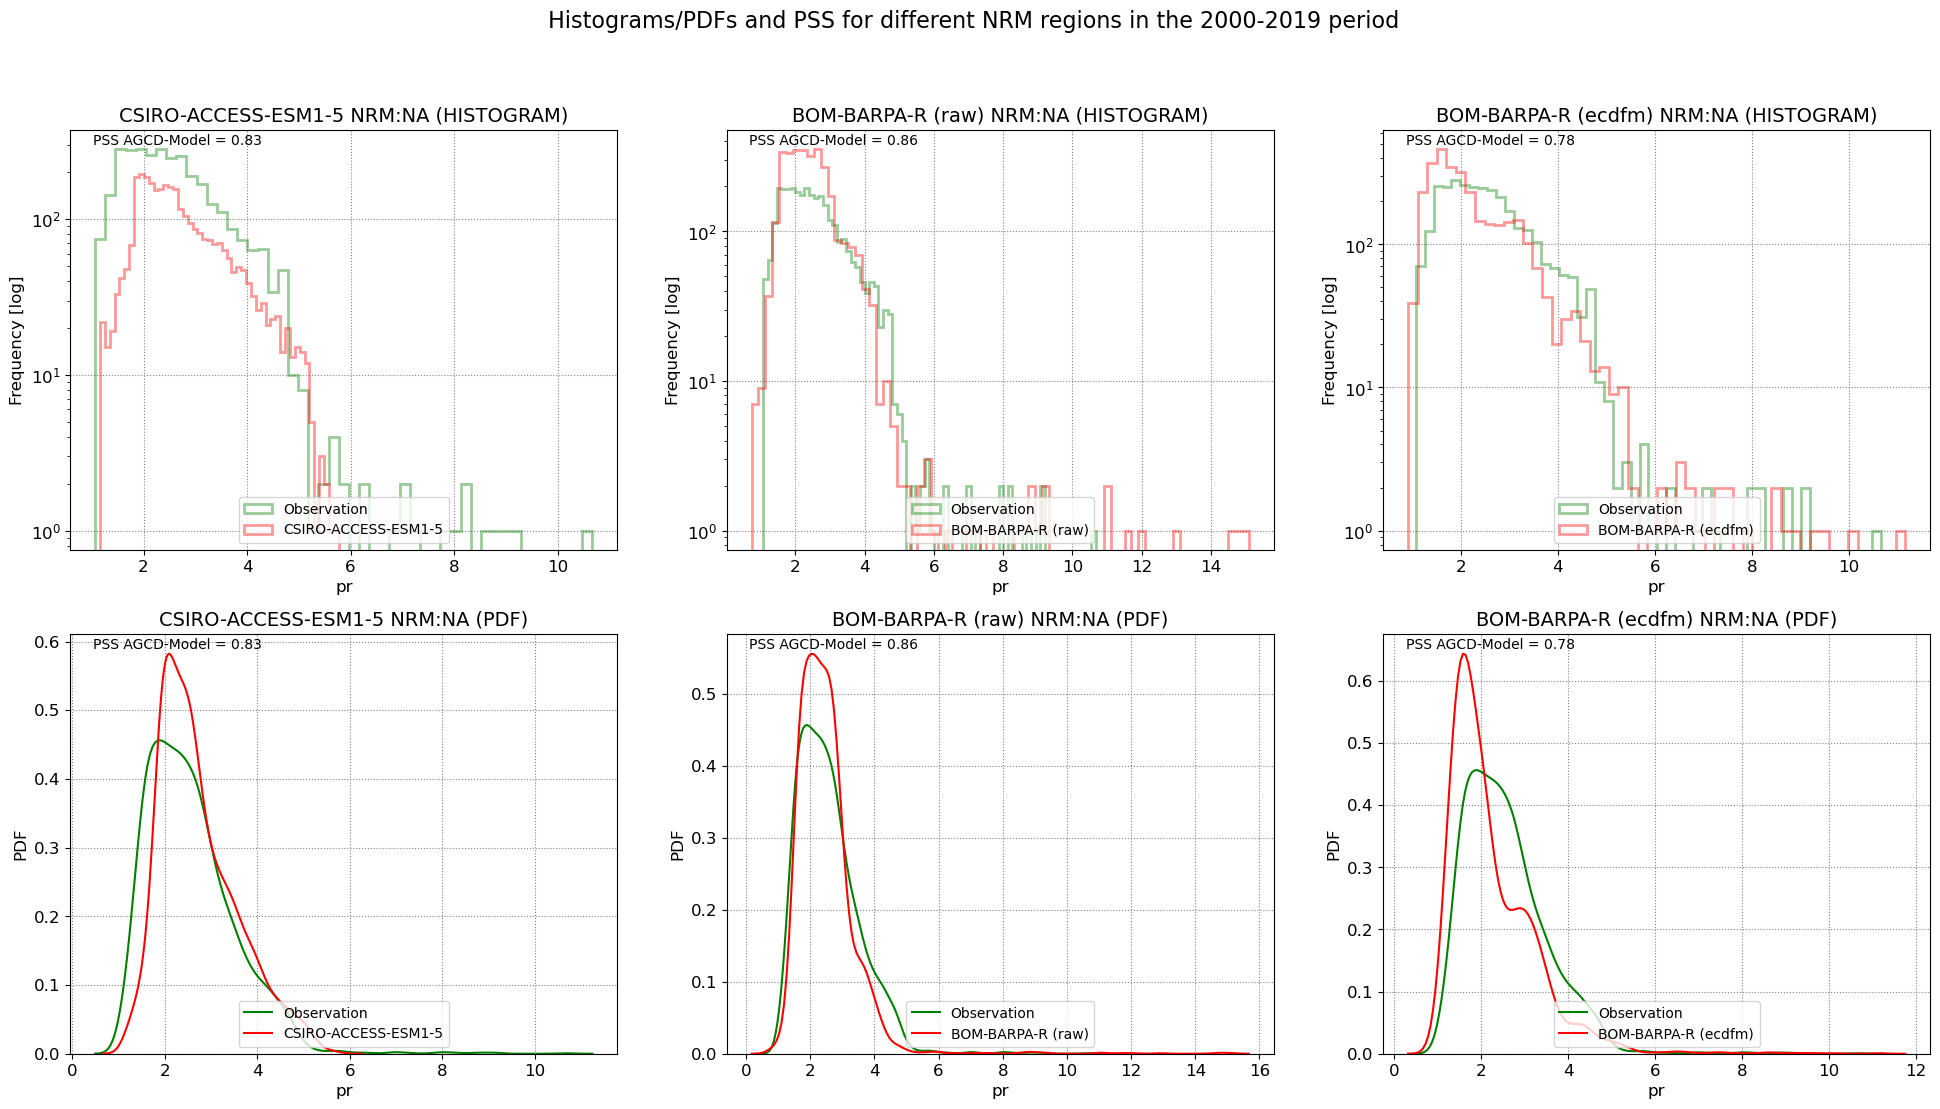

In [36]:
plot_comparison('pr','BOM-BARPA-R','NA')

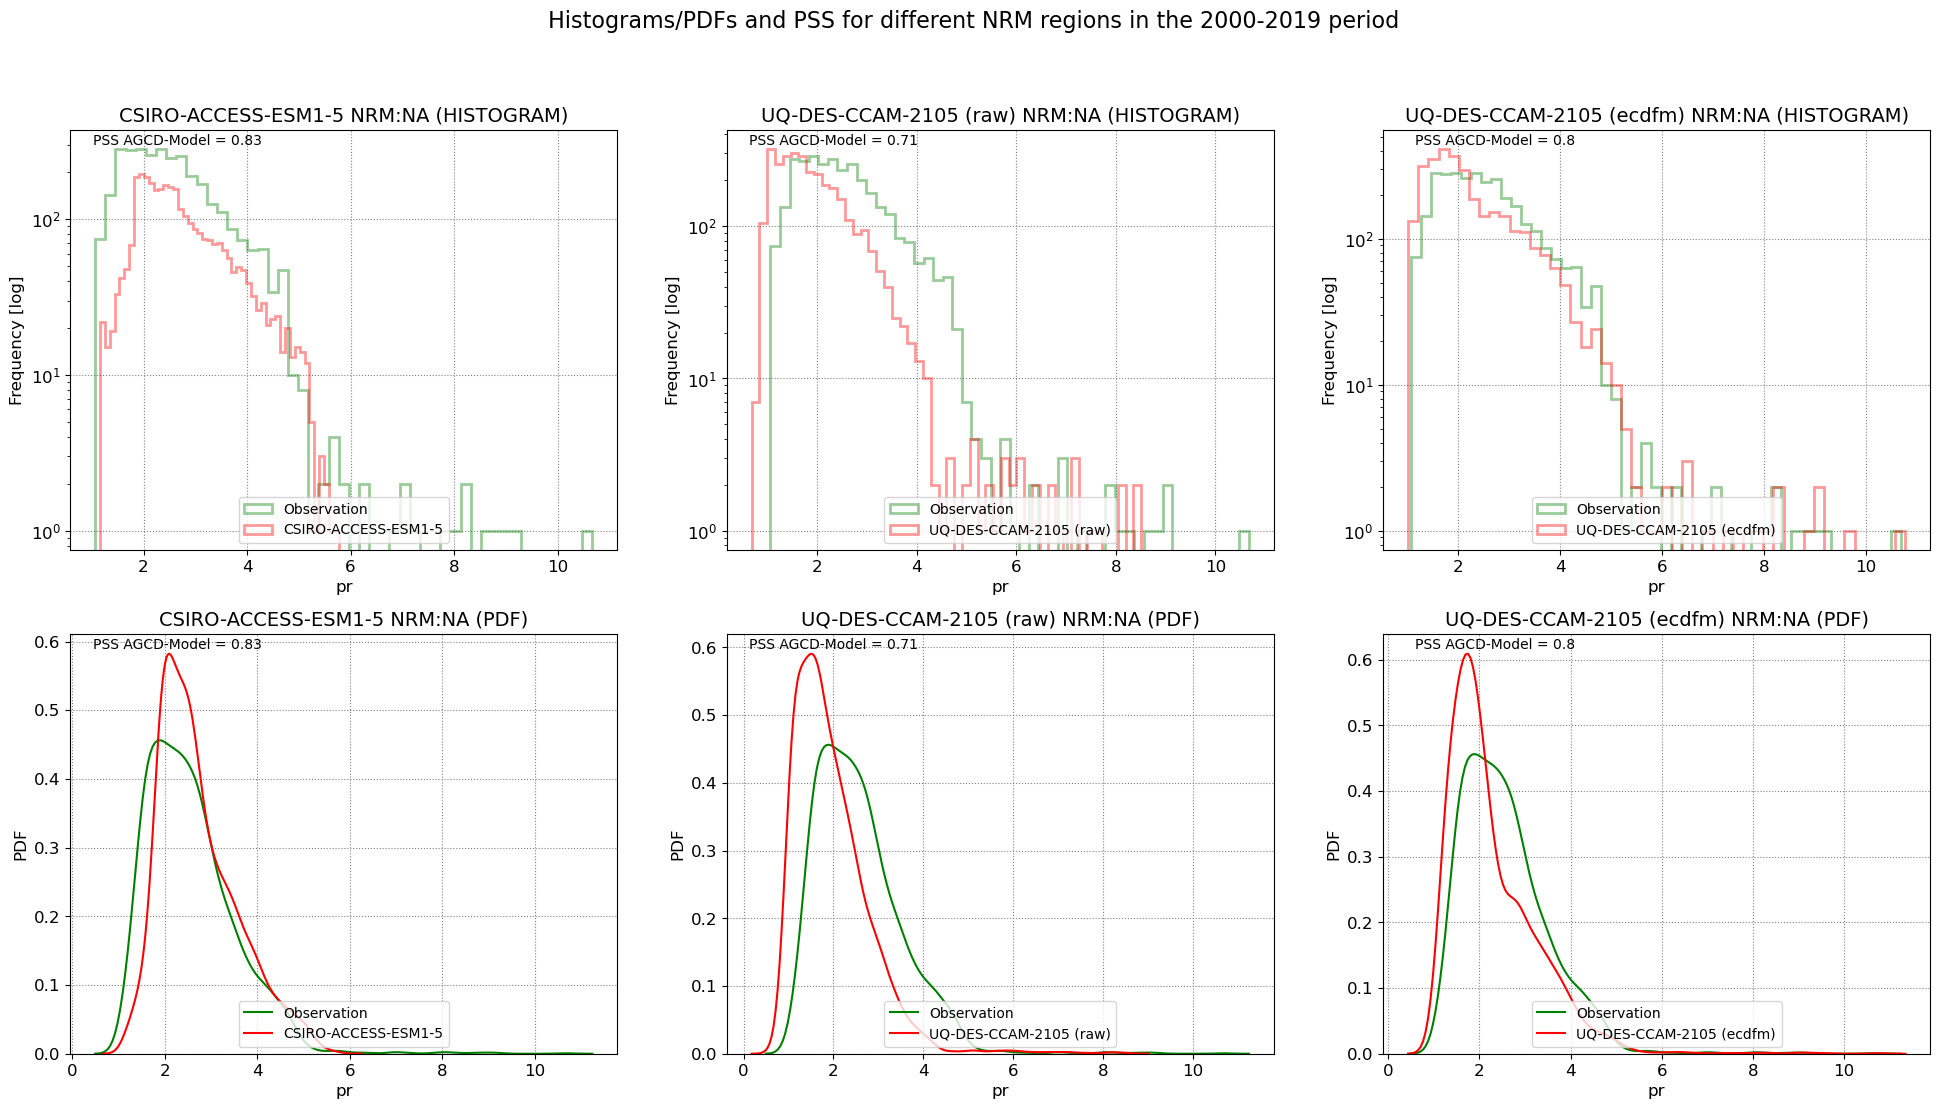

In [37]:
plot_comparison('pr','UQ-DES-CCAM-2105','NA')

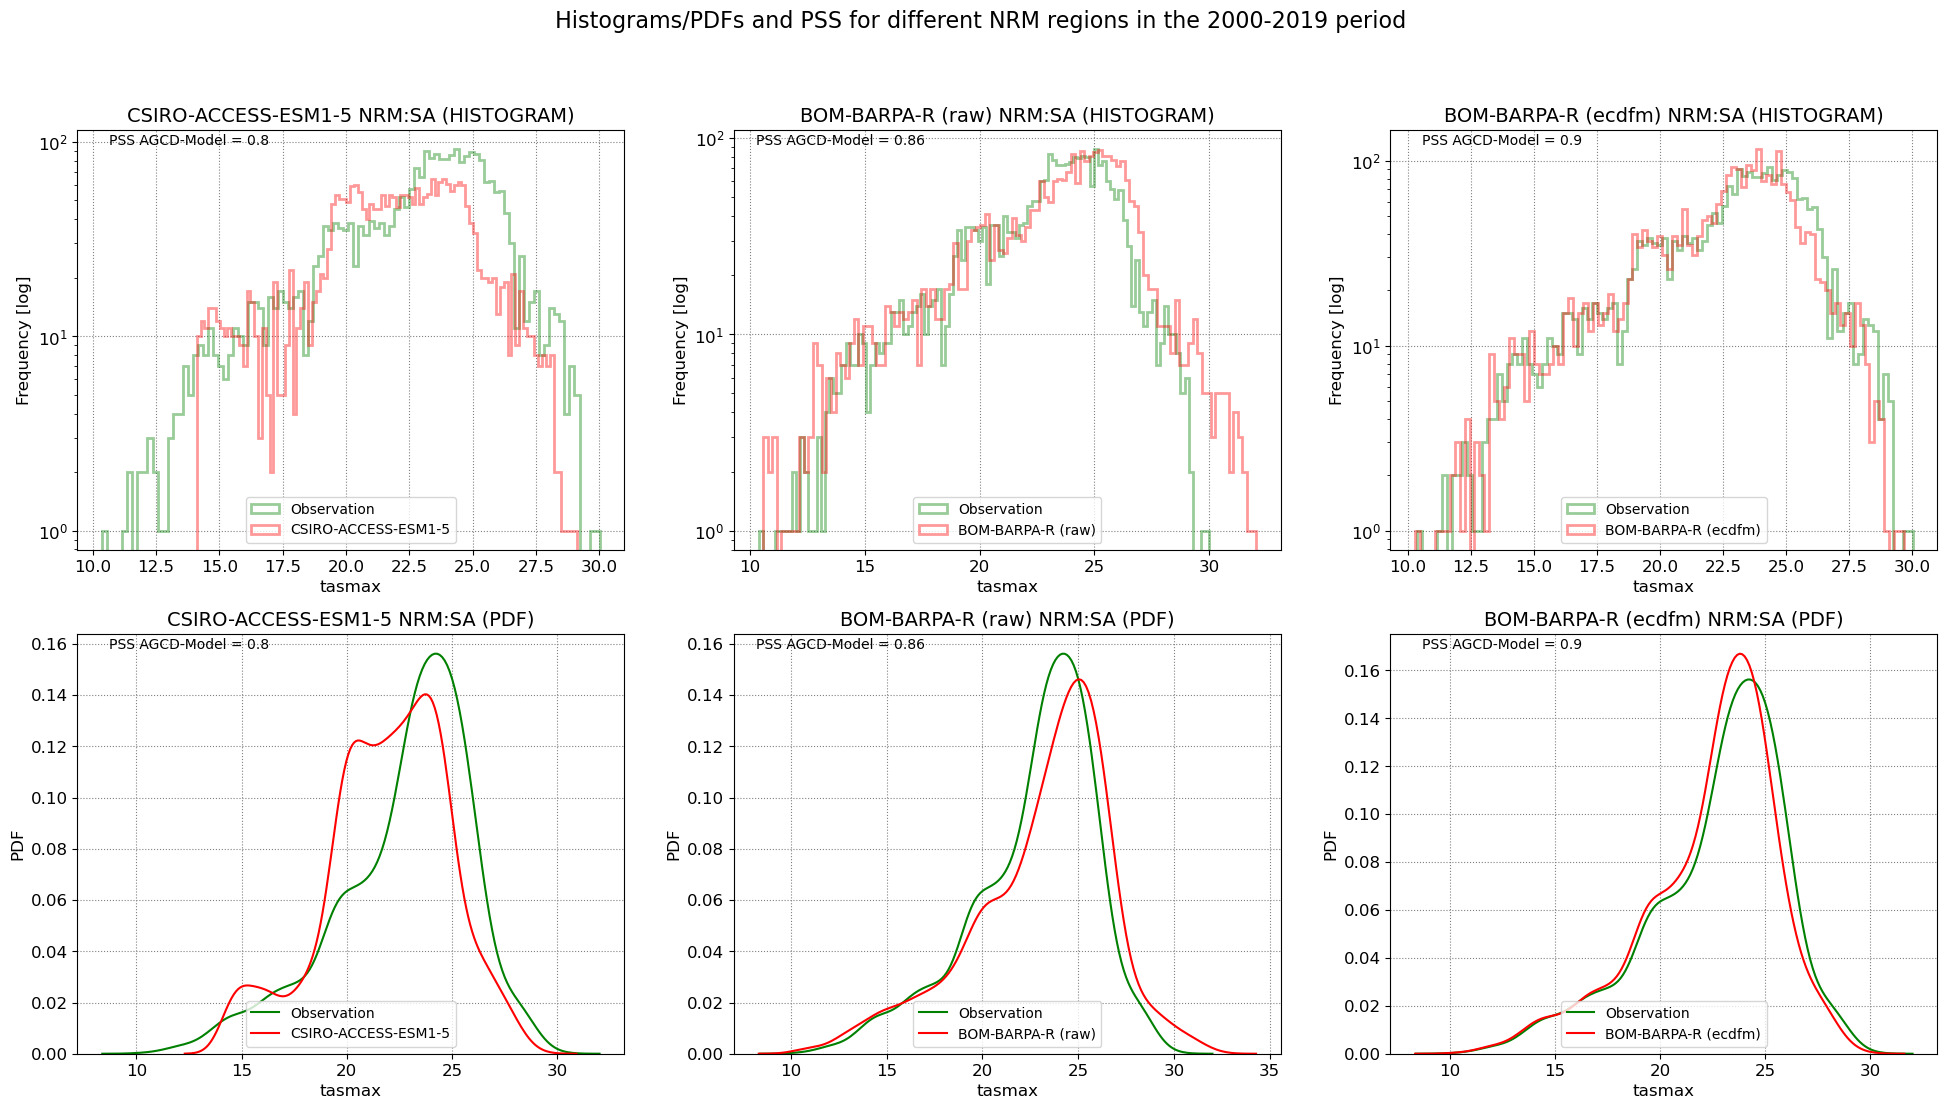

In [38]:
plot_comparison('tasmax','BOM-BARPA-R','SA')

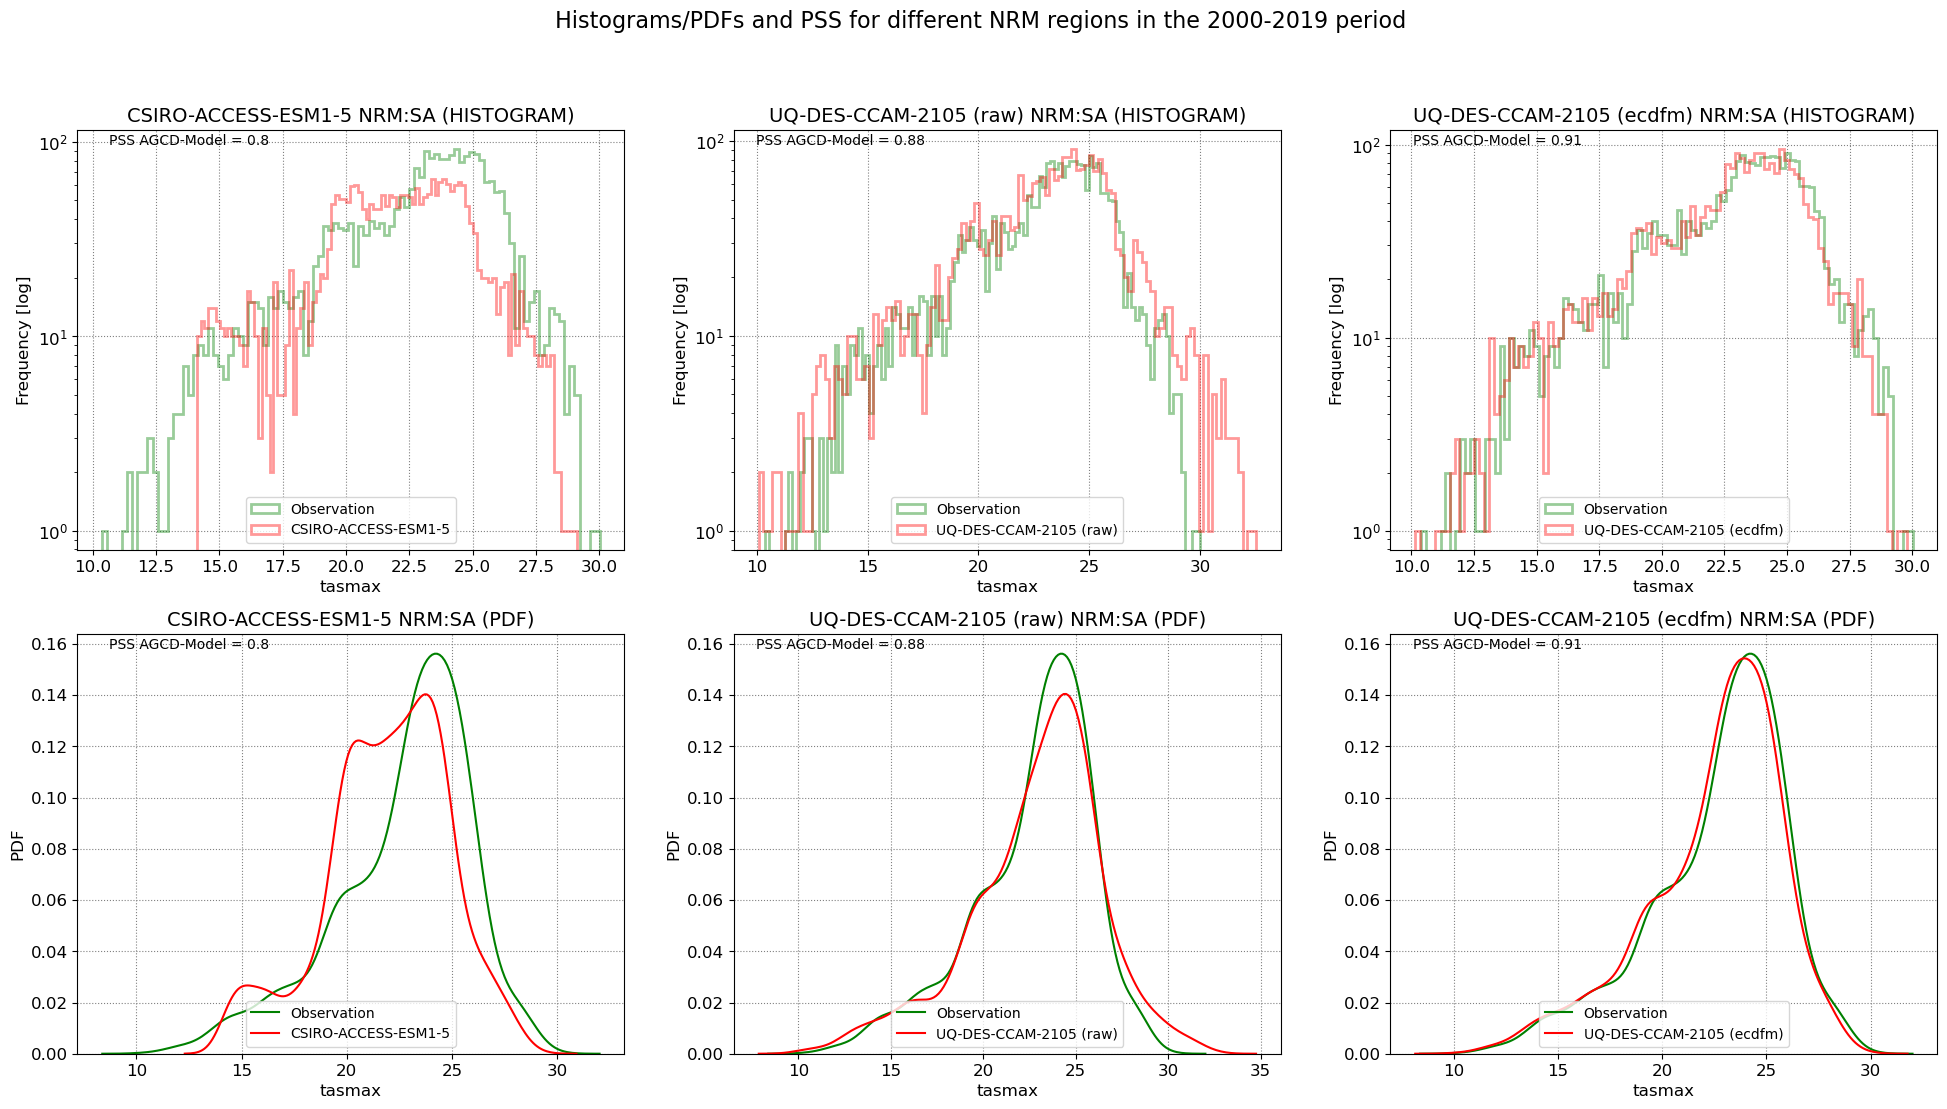

In [39]:
plot_comparison('tasmax','UQ-DES-CCAM-2105','SA')

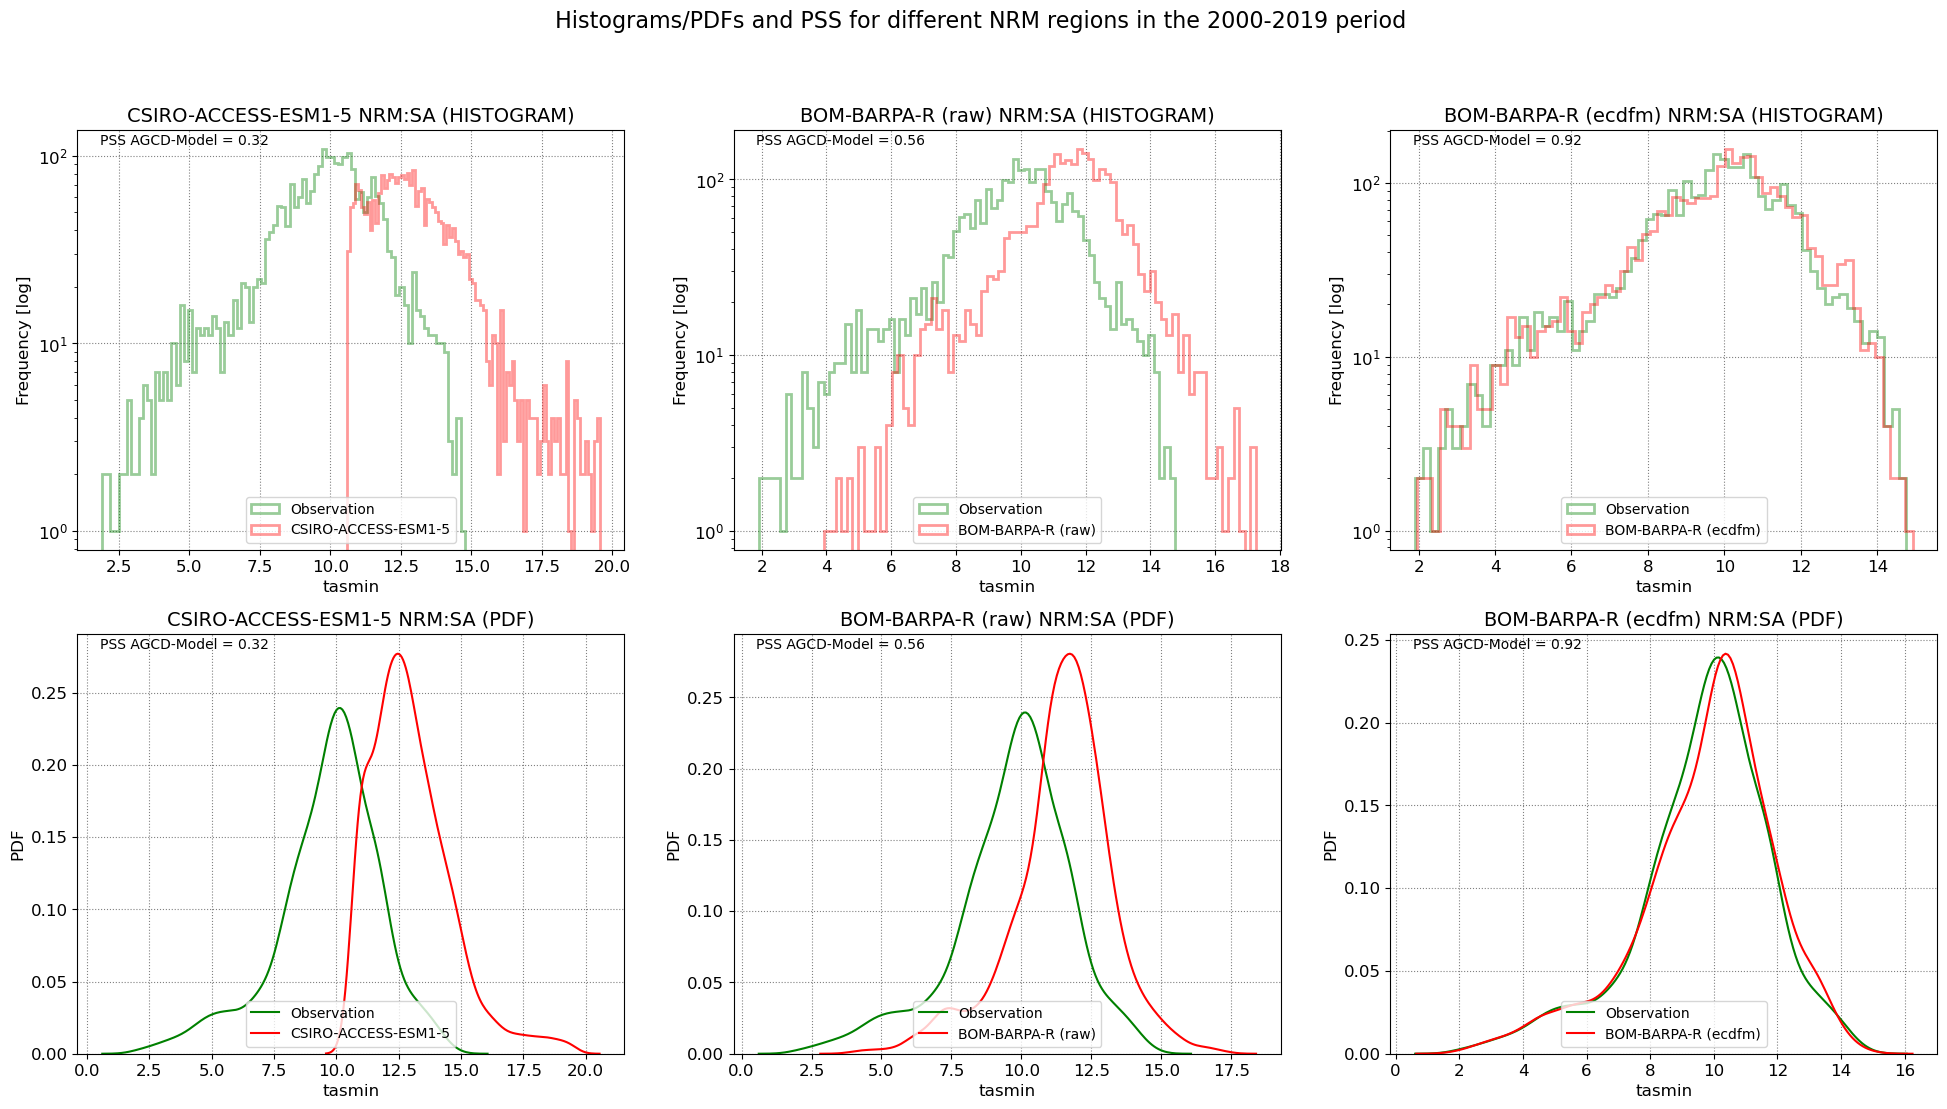

In [40]:
plot_comparison('tasmin','BOM-BARPA-R','SA')

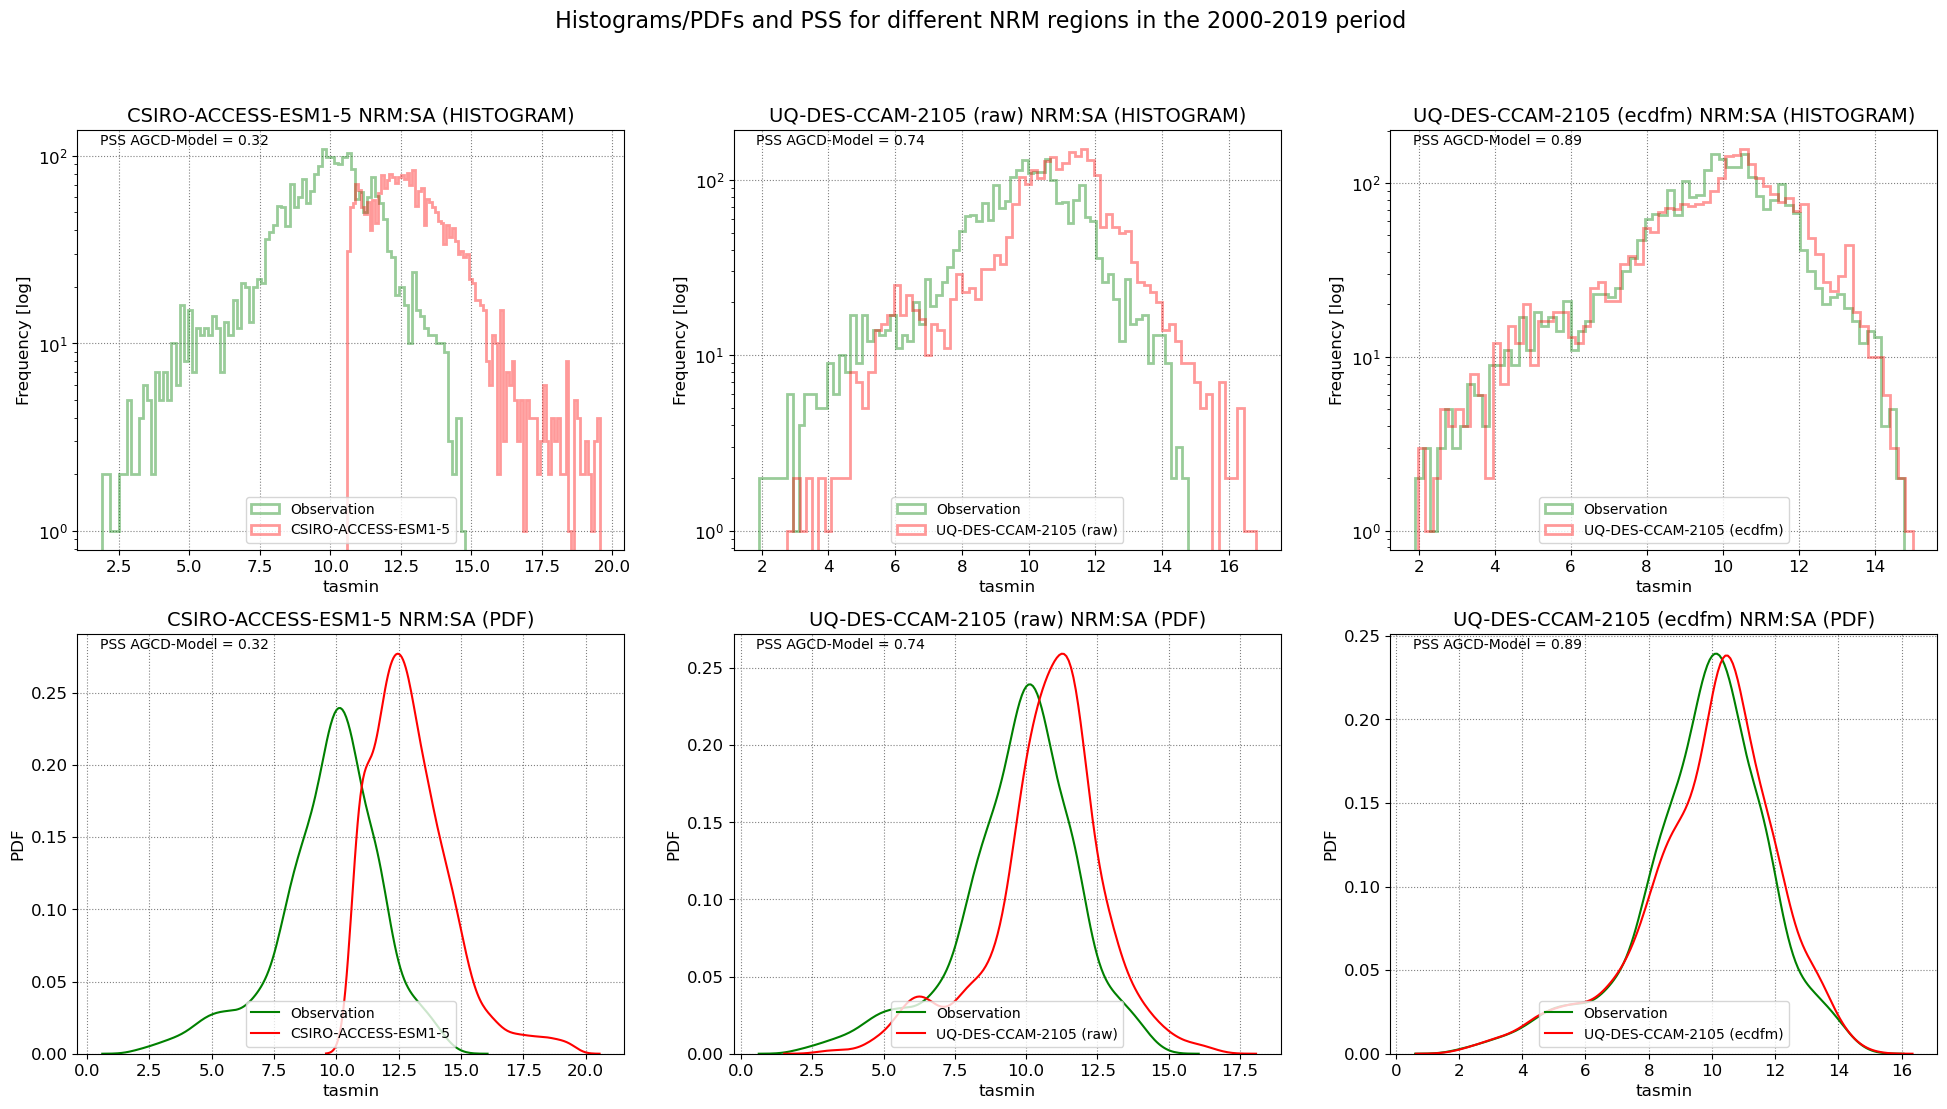

In [41]:
plot_comparison('tasmin','UQ-DES-CCAM-2105','SA')

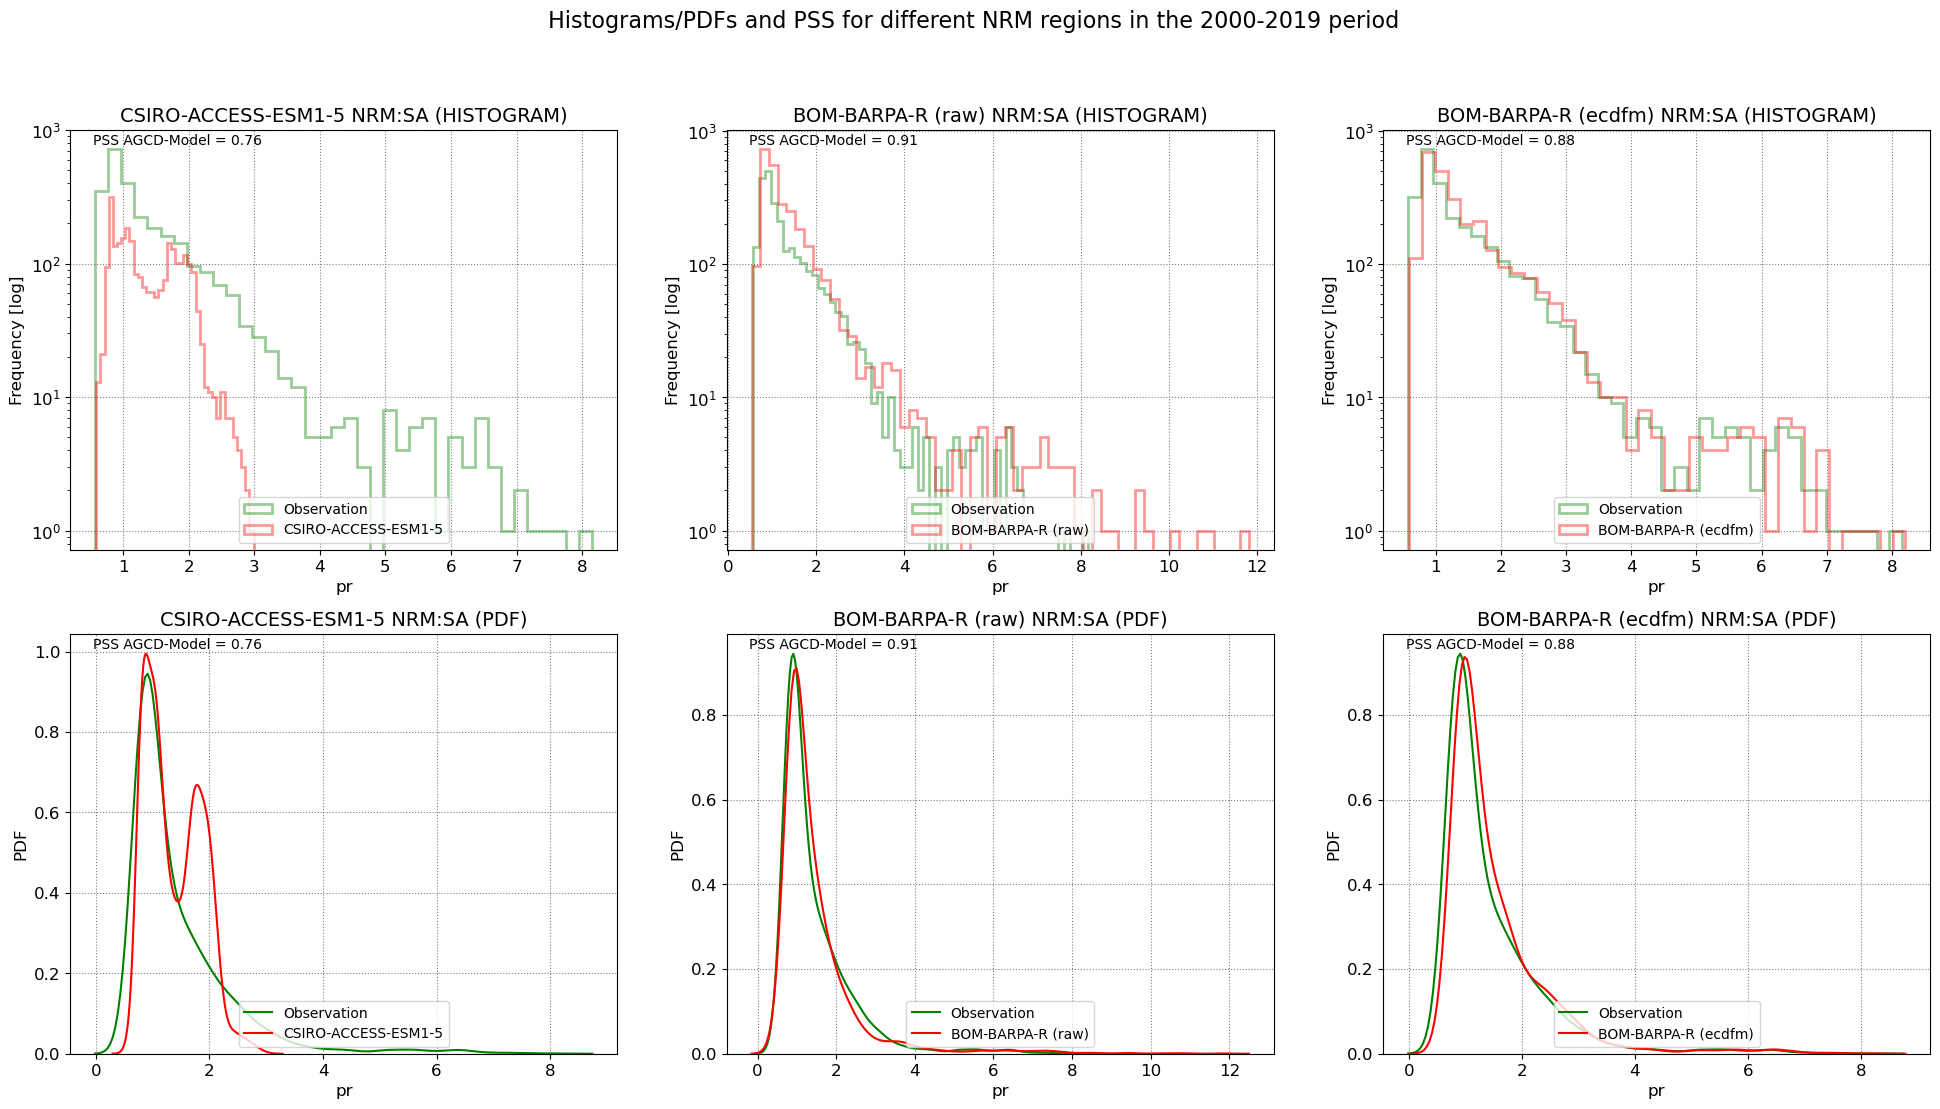

In [42]:
plot_comparison('pr','BOM-BARPA-R','SA')

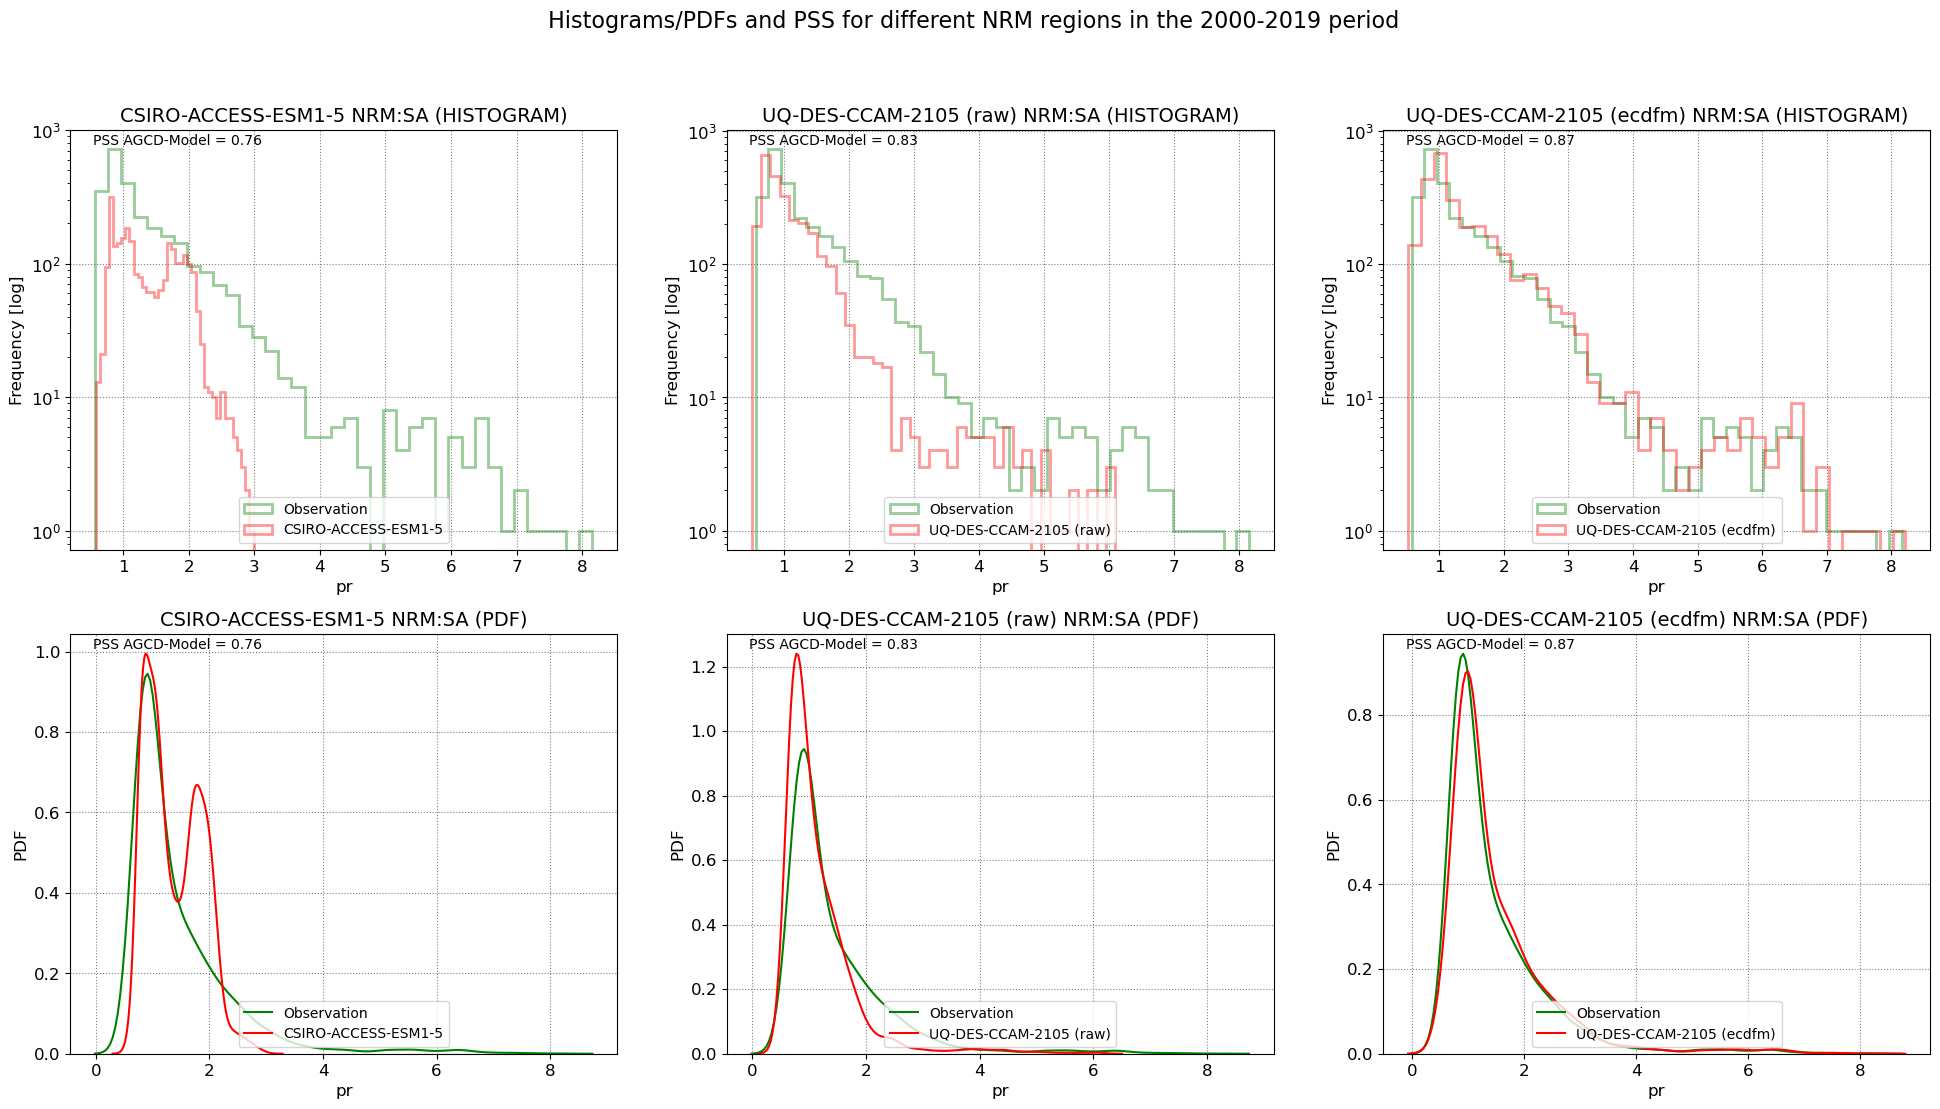

In [43]:
plot_comparison('pr','UQ-DES-CCAM-2105','SA')